**Data Preprocessing - Bejaia**

Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import optuna

Loading the dataset


In [2]:
df = pd.read_csv('Sidi-Bel_Abbes_Region_Dataset.csv') #loads the dataset for Portugal wildfires
print(df.head(), '\n') #displays the first five rows of the dataset
print(df.info(), '\n') #displays summary information and the column names and datatypes of the dataset
print(df.describe()) #displays the statistical summary of the numerical columns of the dataset

   day  month  year  Temperature   RH   Ws  Rain   FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           32   71   12    0.7  57.1  2.5   8.2  0.6  2.8   
1    2      6  2012           30   73   13    4.0  55.7  2.7   7.8  0.6  2.9   
2    3      6  2012           29   80   14    2.0  48.7  2.2   7.6  0.3  2.6   
3    4      6  2012           30   64   14    0.0  79.4  5.2  15.4  2.2  5.6   
4    5      6  2012           32   60   14    0.2  77.1  6.0  17.6  1.8  6.5   

   FWI    Classes    
0  0.2  not fire     
1  0.2  not fire     
2  0.1  not fire     
3  1.0  not fire     
4  0.9  not fire      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          122 non-null    int64  
 1   month        122 non-null    int64  
 2   year         122 non-null    int64  
 3   Temperature  122 non-null    int64  
 4    RH          122 non-nu

Handling of missing values and duplicate instances 

In [3]:
#checks for duplicates and missing values before cleaning 
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

#cleans the dataset for both duplicates and missing values 
df.drop_duplicates(inplace=True) #removes duplicates 
df.dropna(inplace=True) #removes any missing values 

# confirms that duplicates and missing values have been removed
print("duplicates:", df.duplicated().sum())  #checks for duplicates  
print("missing values:", df.isnull().sum().sum()) #checks for missing values

duplicates: 0
missing values: 1
duplicates: 0
missing values: 0


**Data Visualisation and Analysis**

Monthly fire occurence visualisation and analysis

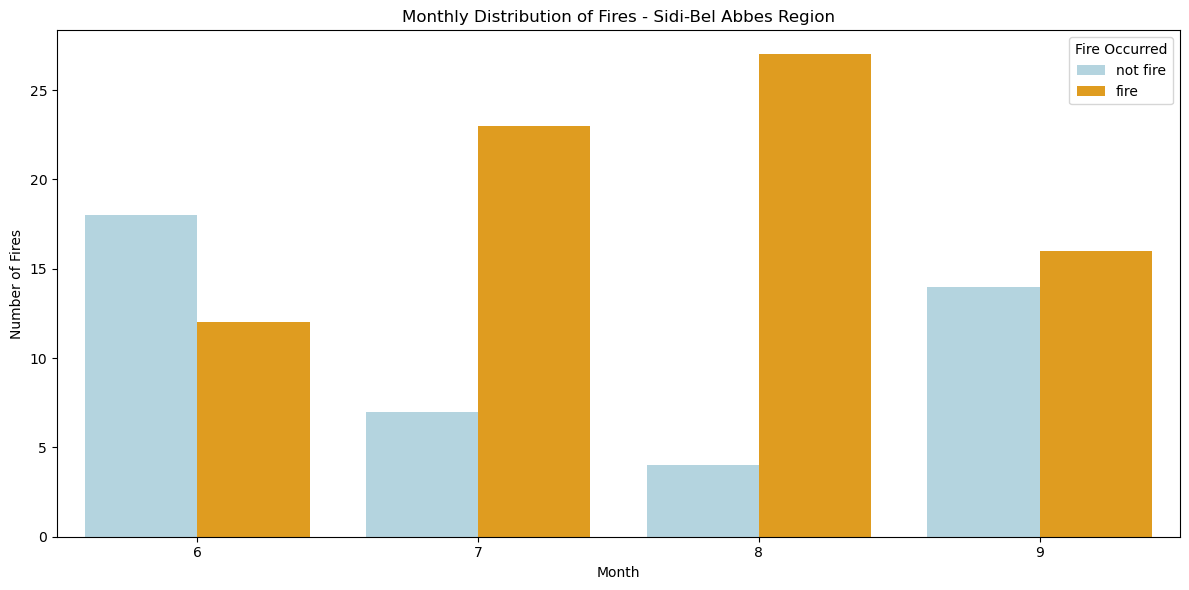

In [4]:
df.columns = df.columns.str.strip()


df['Classes'] = df['Classes'].str.strip()


df['month'] = df['month'].astype(str)

month_order = [str(i) for i in range(6,10)]


plt.figure(figsize=(12, 6))
sns.countplot(
    data=df,
    x='month',
    hue='Classes',
    order=month_order,
    palette={'fire': 'orange', 'not fire': 'lightblue'}
)

plt.title("Monthly Distribution of Fires - Sidi-Bel Abbes Region")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.legend(title='Fire Occurred')
plt.tight_layout()
plt.show()
#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference : https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

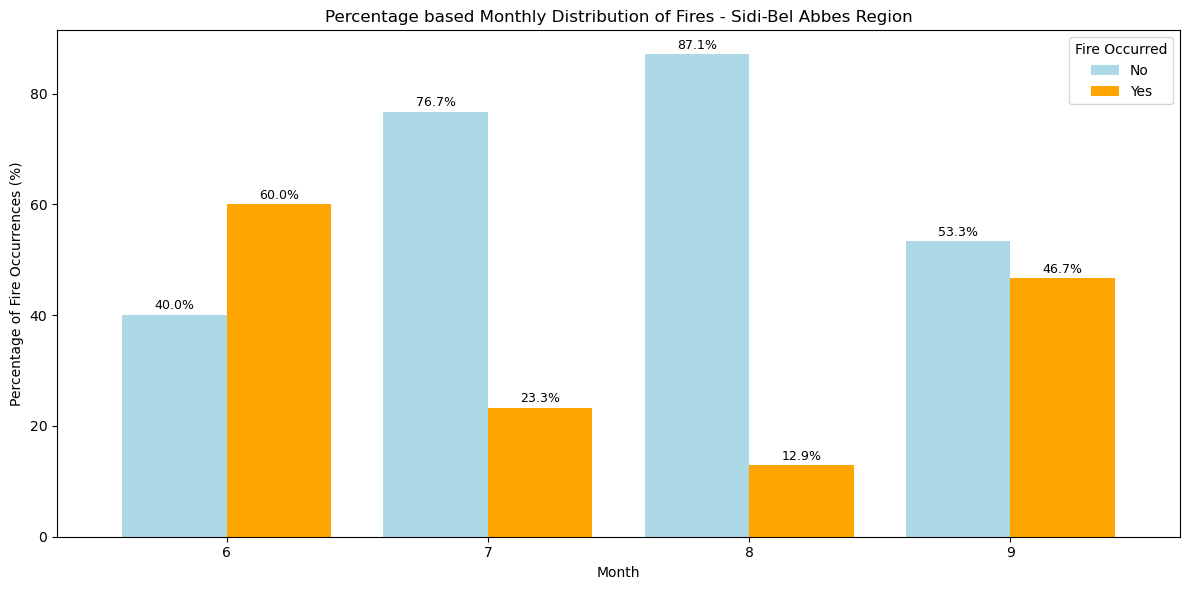

In [5]:
month_order = [str(i) for i in range(6, 10)]

df['month'] = df['month'].astype(str)
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['Classes'] = df['Classes'].str.strip().str.lower()

fire_recorded = df.groupby(['month', 'Classes'], observed=True).size().unstack(fill_value=0)
fire_occurred_percentage = fire_recorded.div(fire_recorded.sum(axis=1), axis=0) * 100

ax = fire_occurred_percentage.plot(
    kind='bar',
    color=['lightblue', 'orange'],
    figsize=(12,6),\
    width=0.8
)

plt.title("Percentage based Monthly Distribution of Fires - Sidi-Bel Abbes Region")
plt.xlabel("Month")
plt.ylabel("Percentage of Fire Occurrences (%)")
plt.legend(title='Fire Occurred', labels=['No','Yes'])
plt.xticks(rotation=0)
plt.tight_layout()

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width()/2,
        p.get_height() + 0.5,
        f'{p.get_height():.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()



#reference: https://seaborn.pydata.org/tutorial/distributions.html
#reference: https://github.com/sai-manas/FWI_Predictor_ML/blob/main/notebook/Algerian_forest_ML_project.ipynb

Correlation Heat Map 

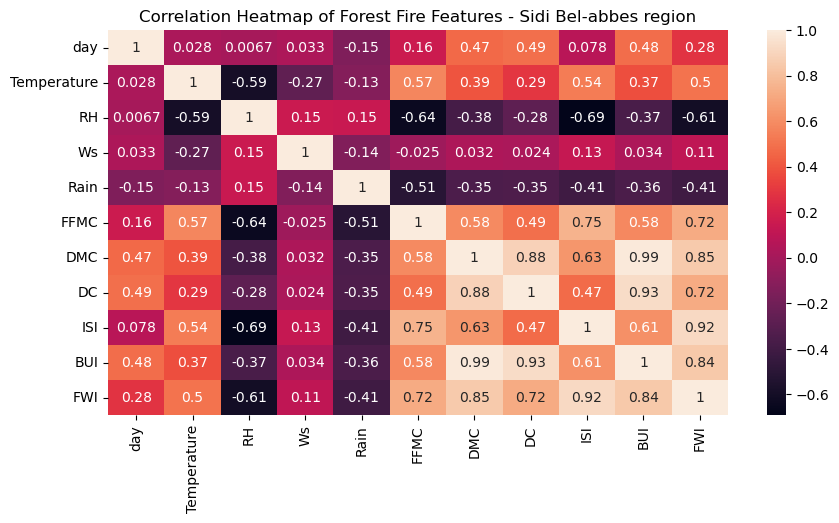

In [6]:
#plots the correlation heatmap - original 

corr_df = df.select_dtypes(include=[float, int]).drop(columns=['year'])

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
)
plt.title("Correlation Heatmap of Forest Fire Features - Sidi Bel-abbes region")
plt.show()
#reference: https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/
#reference: https://www.geeksforgeeks.org/python/how-to-create-a-seaborn-correlation-heatmap-in-python/

Handling of Catergorical Values 

In [7]:
#uses label encoding to map catergorical features to its respective numerical values for month, day, season, fire_occurred

Classes_map = {'fire':1, 'not fire':0}

df['Classes'] = df['Classes'].map(Classes_map)

#reference: https://pandas.pydata.org/docs/dev/reference/api/pandas.Categorical.map.html

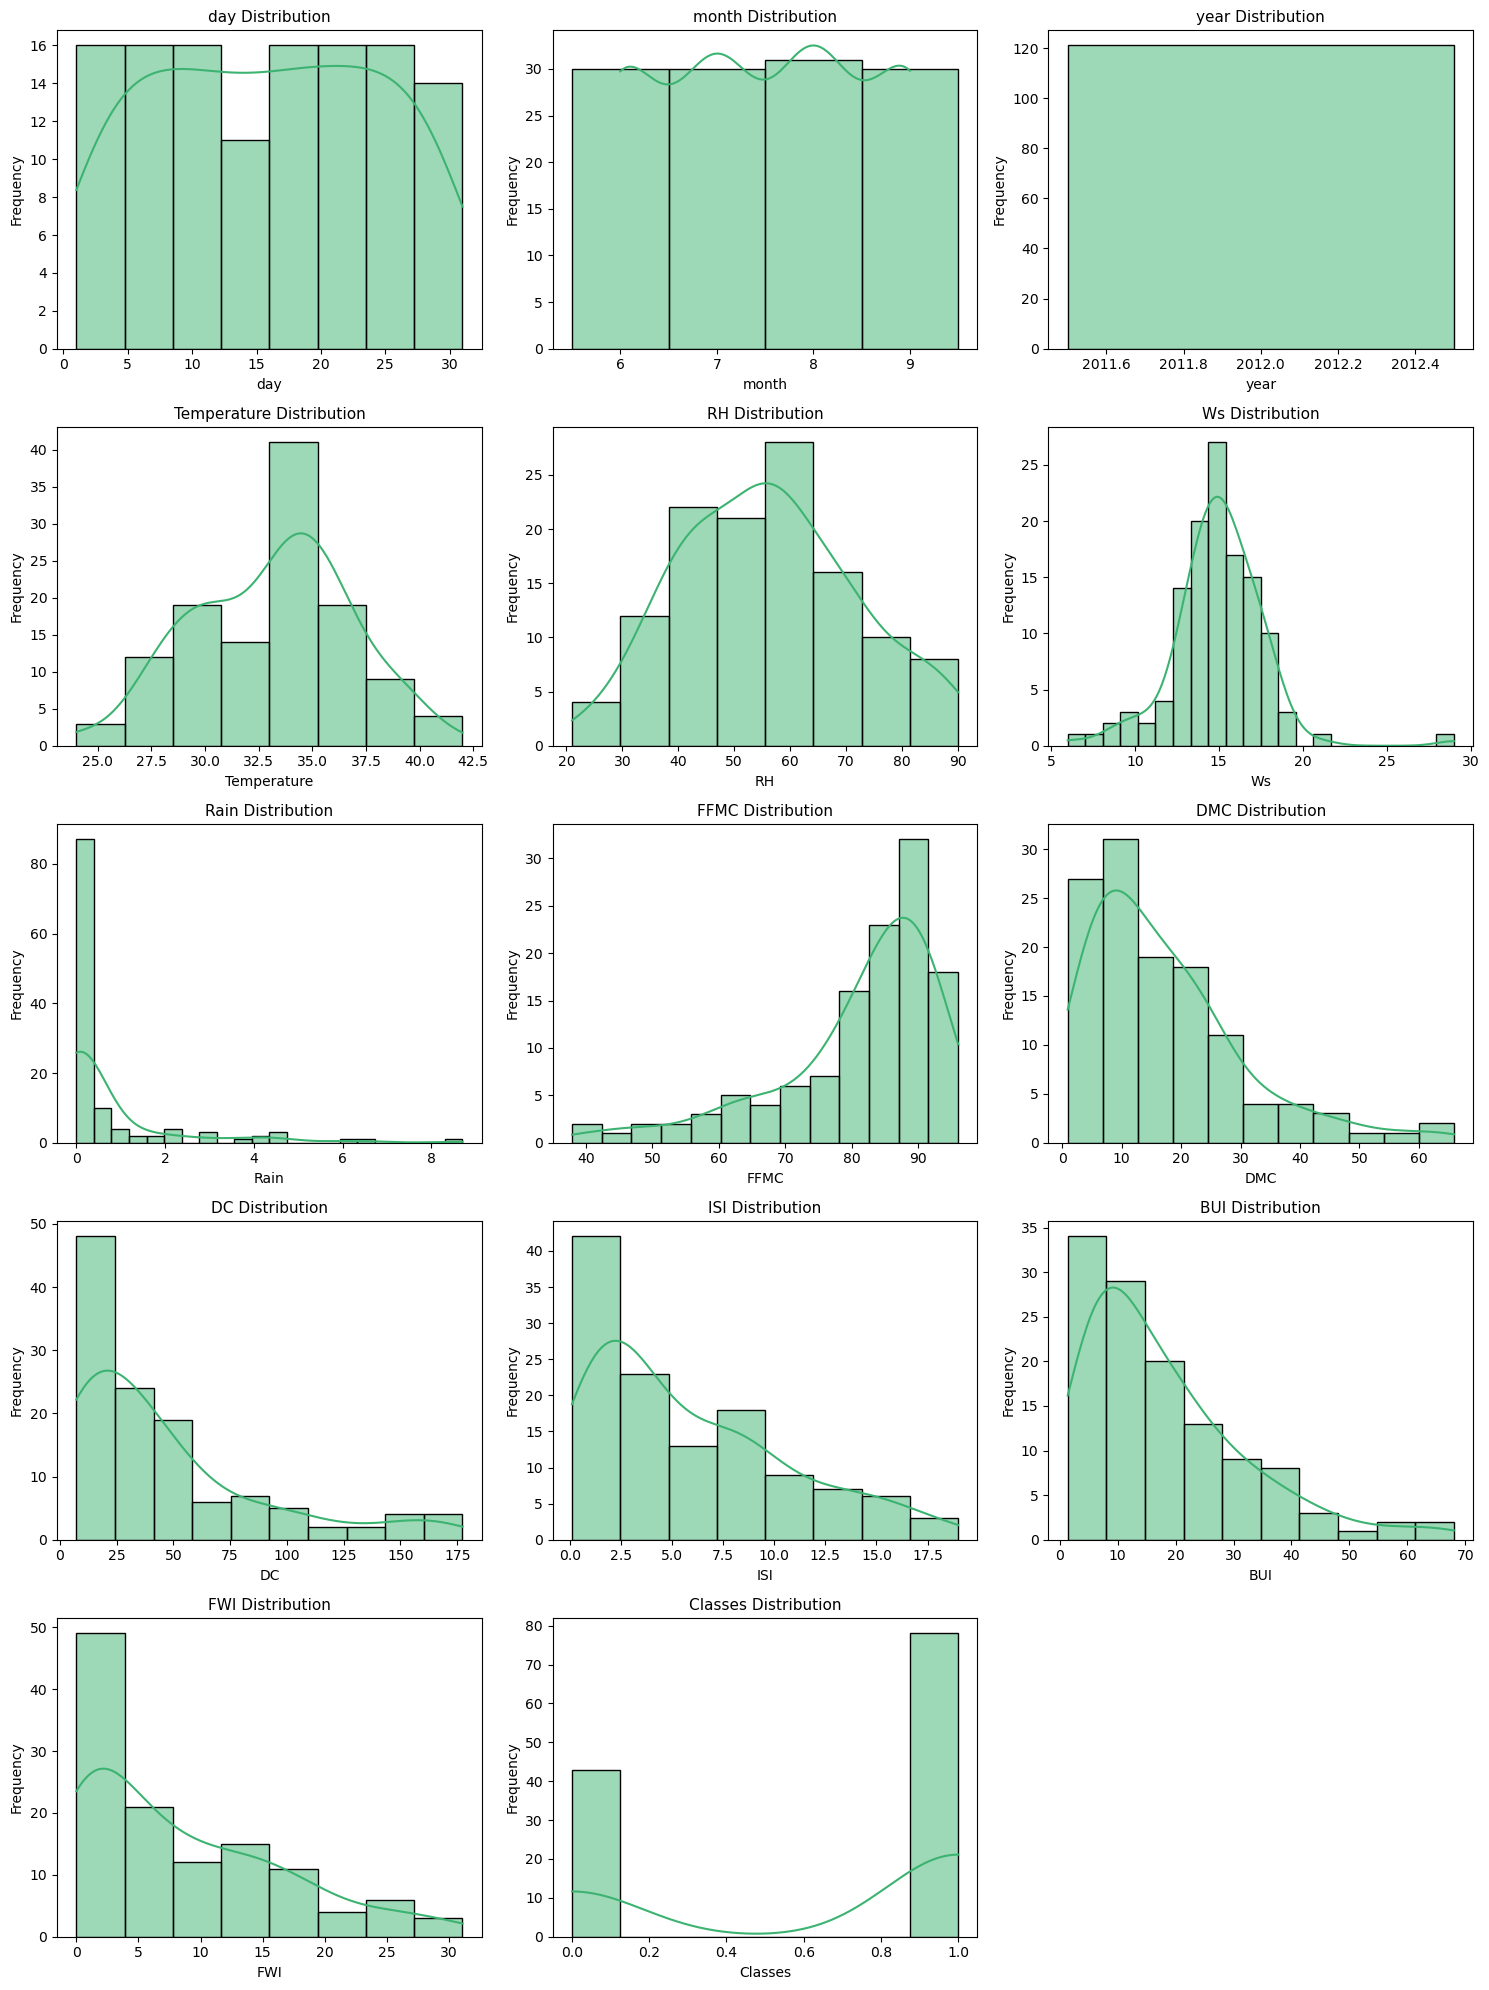

In [8]:

variables = df.columns #all columns in the dataset is used for distribution plotting
cols = 3  #sets the number of plots per row for the figure layout
rows = math.ceil(len(variables) / cols) #calculates the now of rows needed for the figure layout

plt.figure(figsize=(5*cols, 4*rows)) #sets the figure size based on the total number of rows and columns needed

for i, col in enumerate(variables, 1): #iterates thrugh each column 
    plt.subplot(rows, cols, i) #creates a subplot for each column 
    sns.histplot(df[col], kde=True, color='mediumseagreen', edgecolor='black') 
    plt.title(f'{col} Distribution', fontsize=11) #sets the title for each subplot
    plt.xlabel(col) #sets the x-axis label as the column name for each subplot
    plt.ylabel('Frequency') #sets the y-axis label as the frequency for each subplot 

plt.tight_layout()
plt.show()

#reference: https://www.w3schools.com/c/ref_math_ceil.php
#reference: https://www.w3schools.com/python/ref_func_enumerate.asp
#reference: https://www.statology.org/matplotlib-distribution-plot/

**Feature Scaling**

In [9]:
features = df.columns.drop('FWI') #all columns excepts FWI is used as the input features
target = 'FWI' #target variable is set as FWI

X = df[features]
y = df[target]

scaler = StandardScaler()  #standard scaler is used for feature scaling (z-score normalisation)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("Summary after feature scaling:") #the statistical summary is displayed after feature scaling
print(X_scaled.describe().round(2))


Summary after feature scaling:
          day   month   year  Temperature      RH      Ws    Rain    FFMC  \
count  121.00  121.00  121.0       121.00  121.00  121.00  121.00  121.00   
mean     0.00    0.00    0.0        -0.00    0.00   -0.00   -0.00    0.00   
std      1.00    1.00    0.0         1.00    1.00    1.00    1.00    1.00   
min     -1.67   -1.35    0.0        -2.50   -2.24   -3.35   -0.46   -3.53   
25%     -0.88   -0.45    0.0        -0.86   -0.77   -0.37   -0.46   -0.29   
50%      0.03    0.44    0.0         0.24   -0.00    0.01   -0.46    0.30   
75%      0.82    0.44    0.0         0.78    0.70    0.38   -0.12    0.68   
max      1.72    1.34    0.0         2.42    2.17    5.23    5.39    1.22   

          DMC      DC     ISI     BUI  Classes  
count  121.00  121.00  121.00  121.00   121.00  
mean    -0.00   -0.00   -0.00   -0.00     0.00  
std      1.00    1.00    1.00    1.00     1.00  
min     -1.24   -0.90   -1.20   -1.20    -1.35  
25%     -0.76   -0.72   -0.84 

Box plot visualisation 

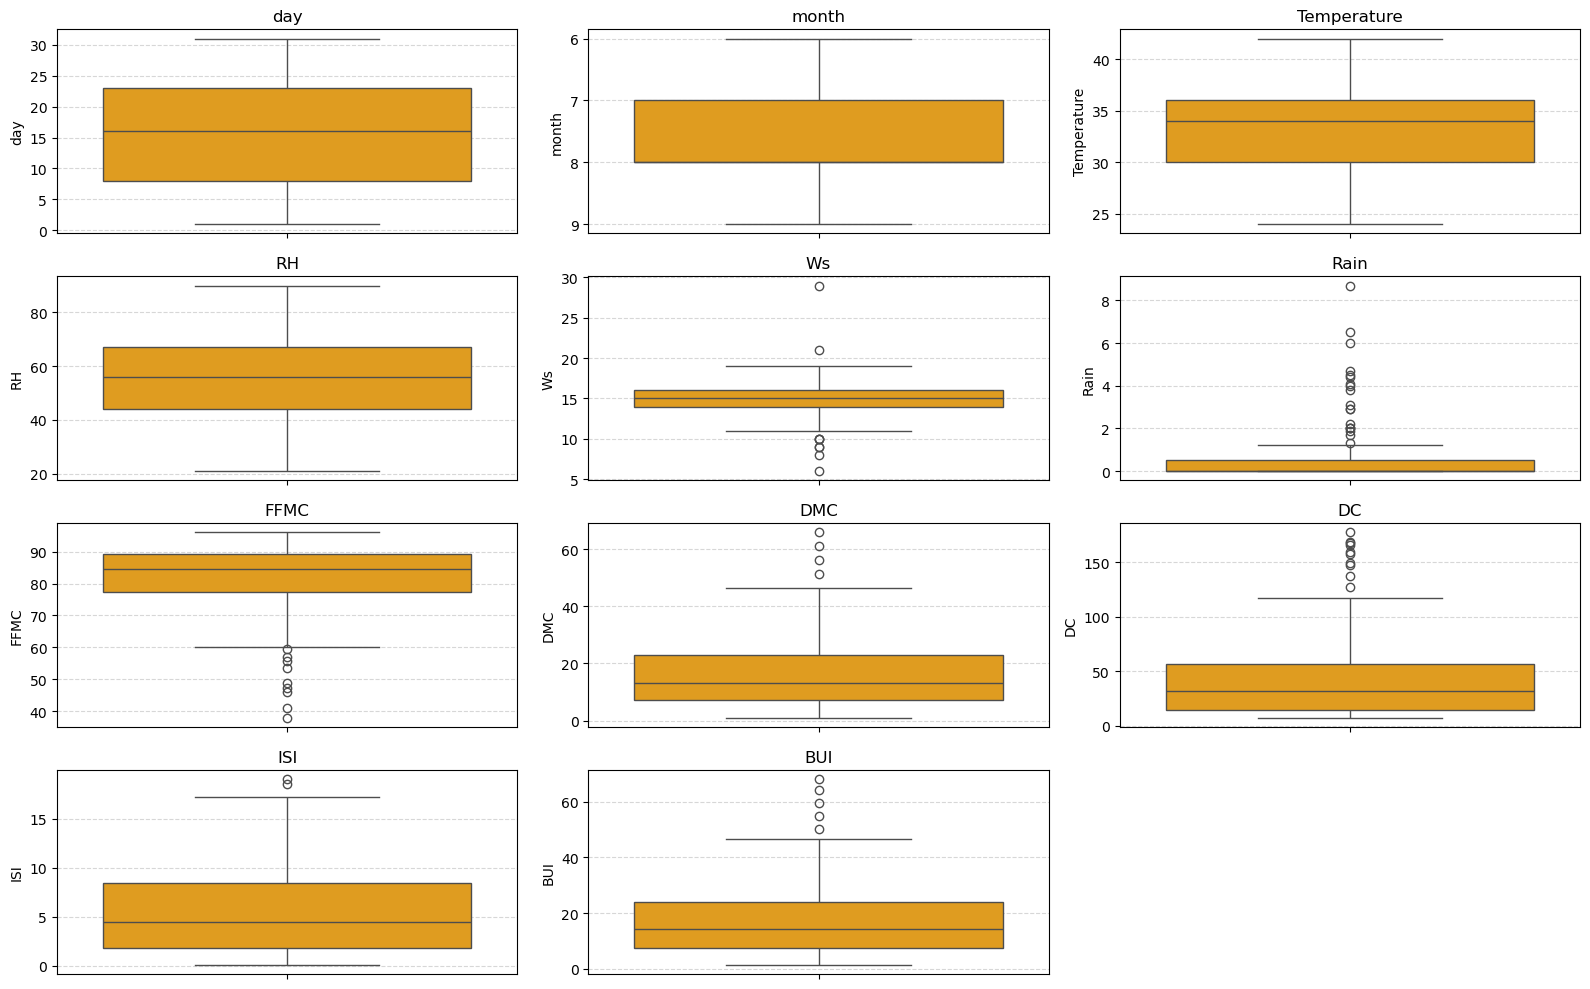

In [10]:

#box plot visualisation of the features after feature scaling
features = ["day", "month",	"Temperature","RH","Ws","Rain", "FFMC","DMC","DC","ISI","BUI"] #only the most relevant features are plotted (research is based on weather data and fire indices)

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)      #creates a subplot for each feature and includes it in a 3 by 3 grid layout
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

Handling of Outliers

Original dataset size: 121
Dataset size after capping outliers: 121


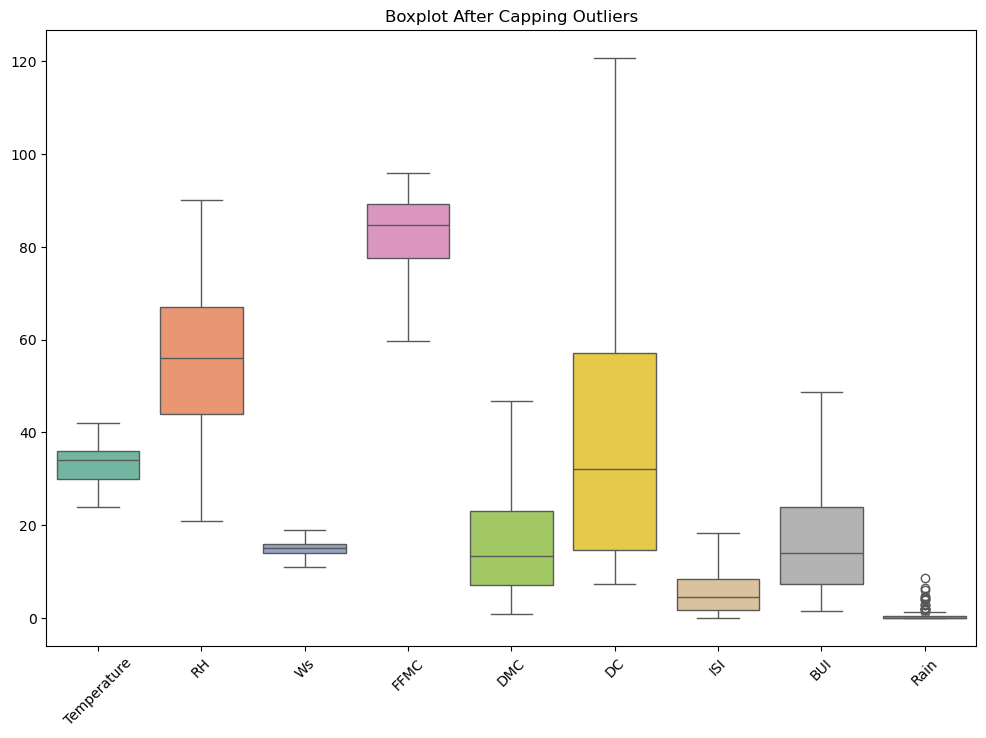

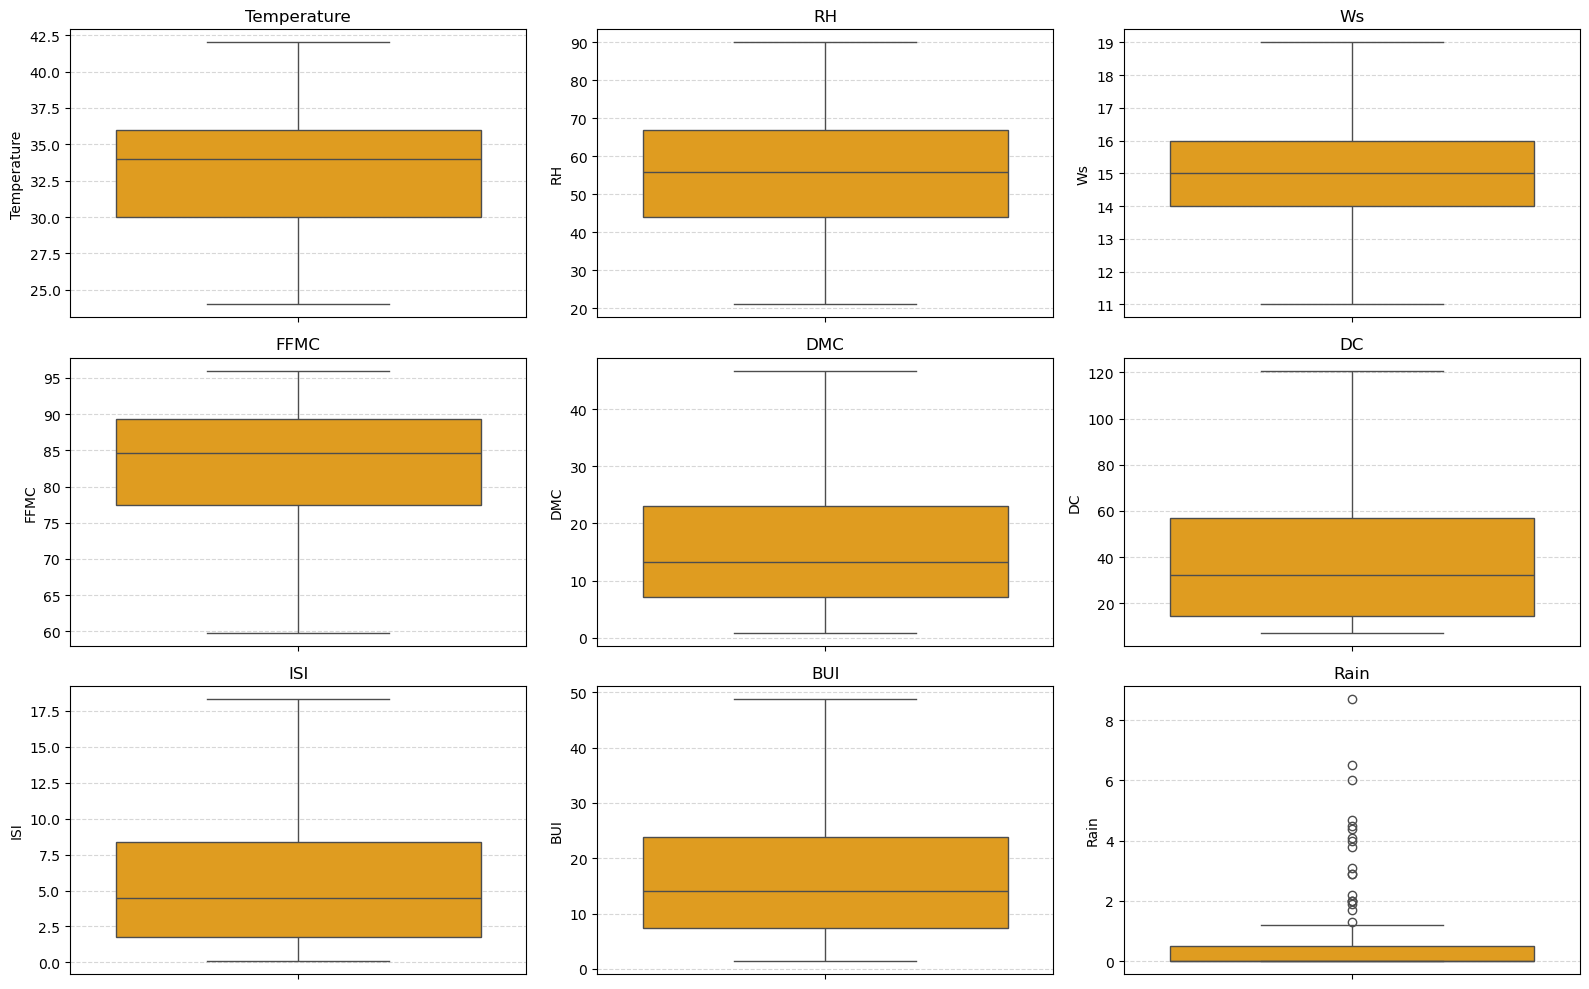

In [11]:

# following fuction is used to limit extreme values using IQR method


def cap_outliers(df, columns, factor=1.5): # k = 1.5 
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df[col] = np.clip(df[col], lower, upper) #caps/replaces values outside the lower and upper bounds 
    return df

features =  ["Temperature","RH","Ws", "FFMC","DMC","DC","ISI","BUI"] #most relavant features (numerical) for the FWI is used 

df = cap_outliers(df, features) #caps the outliers using the preivously defined function (cap_outliers)

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after capping outliers: {df.shape[0]}")  # prints the size of the dataset after capping outliers to ensure the size is unchanged


scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features +['Rain']]) #features scales the capped dataset

#plots boxplots to visualise the capped outliers and ensure no outliers are present
plt.figure(figsize=(12,8))
sns.boxplot(data=df[features+['Rain']], palette="Set2")
plt.title("Boxplot After Capping Outliers")
plt.xticks(rotation=45)
plt.show()

# plots individual boxplots for a better visualisation of each feature in a 3 by 3 grid layout (easier to compare with the previous boxplot before capping)
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features+['Rain'], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature], color="orange")
    plt.title(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
#reference: https://www.geeksforgeeks.org/data-visualization/box-plot-in-python-using-matplotlib/
#reference: https://stackoverflow.com/questions/42207920/how-to-take-floor-and-capping-for-removing-outliers
#reference: https://stackoverflow.com/questions/59593943/multiple-boxplots-of-all-categorical-variables-in-one-plotting-window-using-seab

**Feature Importance**

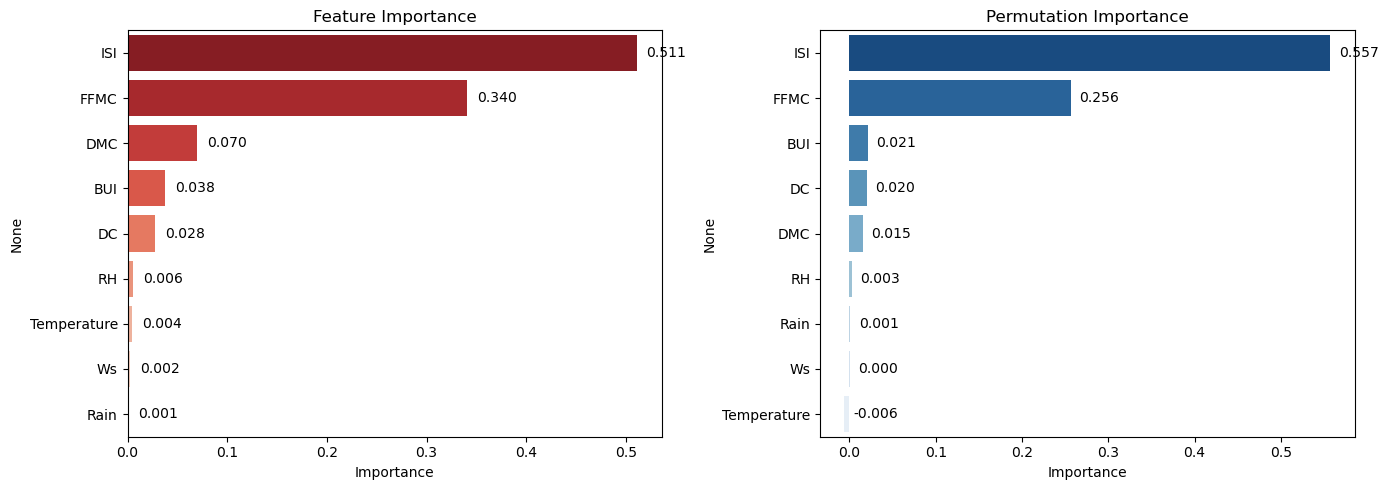

Feature Importance Comparison:
             Built-in  Permutation
BUI             0.038        0.021
DC              0.028        0.020
DMC             0.070        0.015
FFMC            0.340        0.256
ISI             0.511        0.557
RH              0.006        0.003
Rain            0.001        0.001
Temperature     0.004       -0.006
Ws              0.002        0.000


In [12]:

features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"] #same most relevant features as before is used 
target = 'FWI'

X = df[features] #capped dataset is used for training the RF model 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #data is split into 80% training and 20% testing

model = RandomForestRegressor(n_estimators=100, random_state=42) #random forest regressor model is used with 100 trees/estimators 
model.fit(X_train, y_train)

#mdi feature importance and permutation feature importance are calculated
mdi_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False) #built-in feature importance from the random forest model 
perm_result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42) 
perm_importances = pd.Series(perm_result.importances_mean, index=features).sort_values(ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for MDI - built-in feature importance
sns.barplot(x=mdi_importances.values, y=mdi_importances.index, hue=mdi_importances.index, 
            palette='Reds_r', ax=axes[0], legend=False)
axes[0].set_title('Feature Importance')
axes[0].set_xlabel('Importance')

for i, v in enumerate(mdi_importances.values): #values for each bar is added on the barplot
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

# Plot 2 for the permutation feature importance
sns.barplot(x=perm_importances.values, y=perm_importances.index, hue=perm_importances.index,
            palette='Blues_r', ax=axes[1], legend=False)
axes[1].set_title('Permutation Importance')
axes[1].set_xlabel('Importance')

for i, v in enumerate(perm_importances.values): #values for each bar is added on the barplot
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

#feature comparison table is printed 
print("Feature Importance Comparison:")
print(pd.DataFrame({'Built-in': mdi_importances, 'Permutation': perm_importances}).round(3))

#reference: https://www.geeksforgeeks.org/machine-learning/feature-importance-with-random-forests/ (built-in feature importance)
#reference: https://scikit-learn.org/stable/modules/permutation_importance.html
#reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Pearson Correlation 

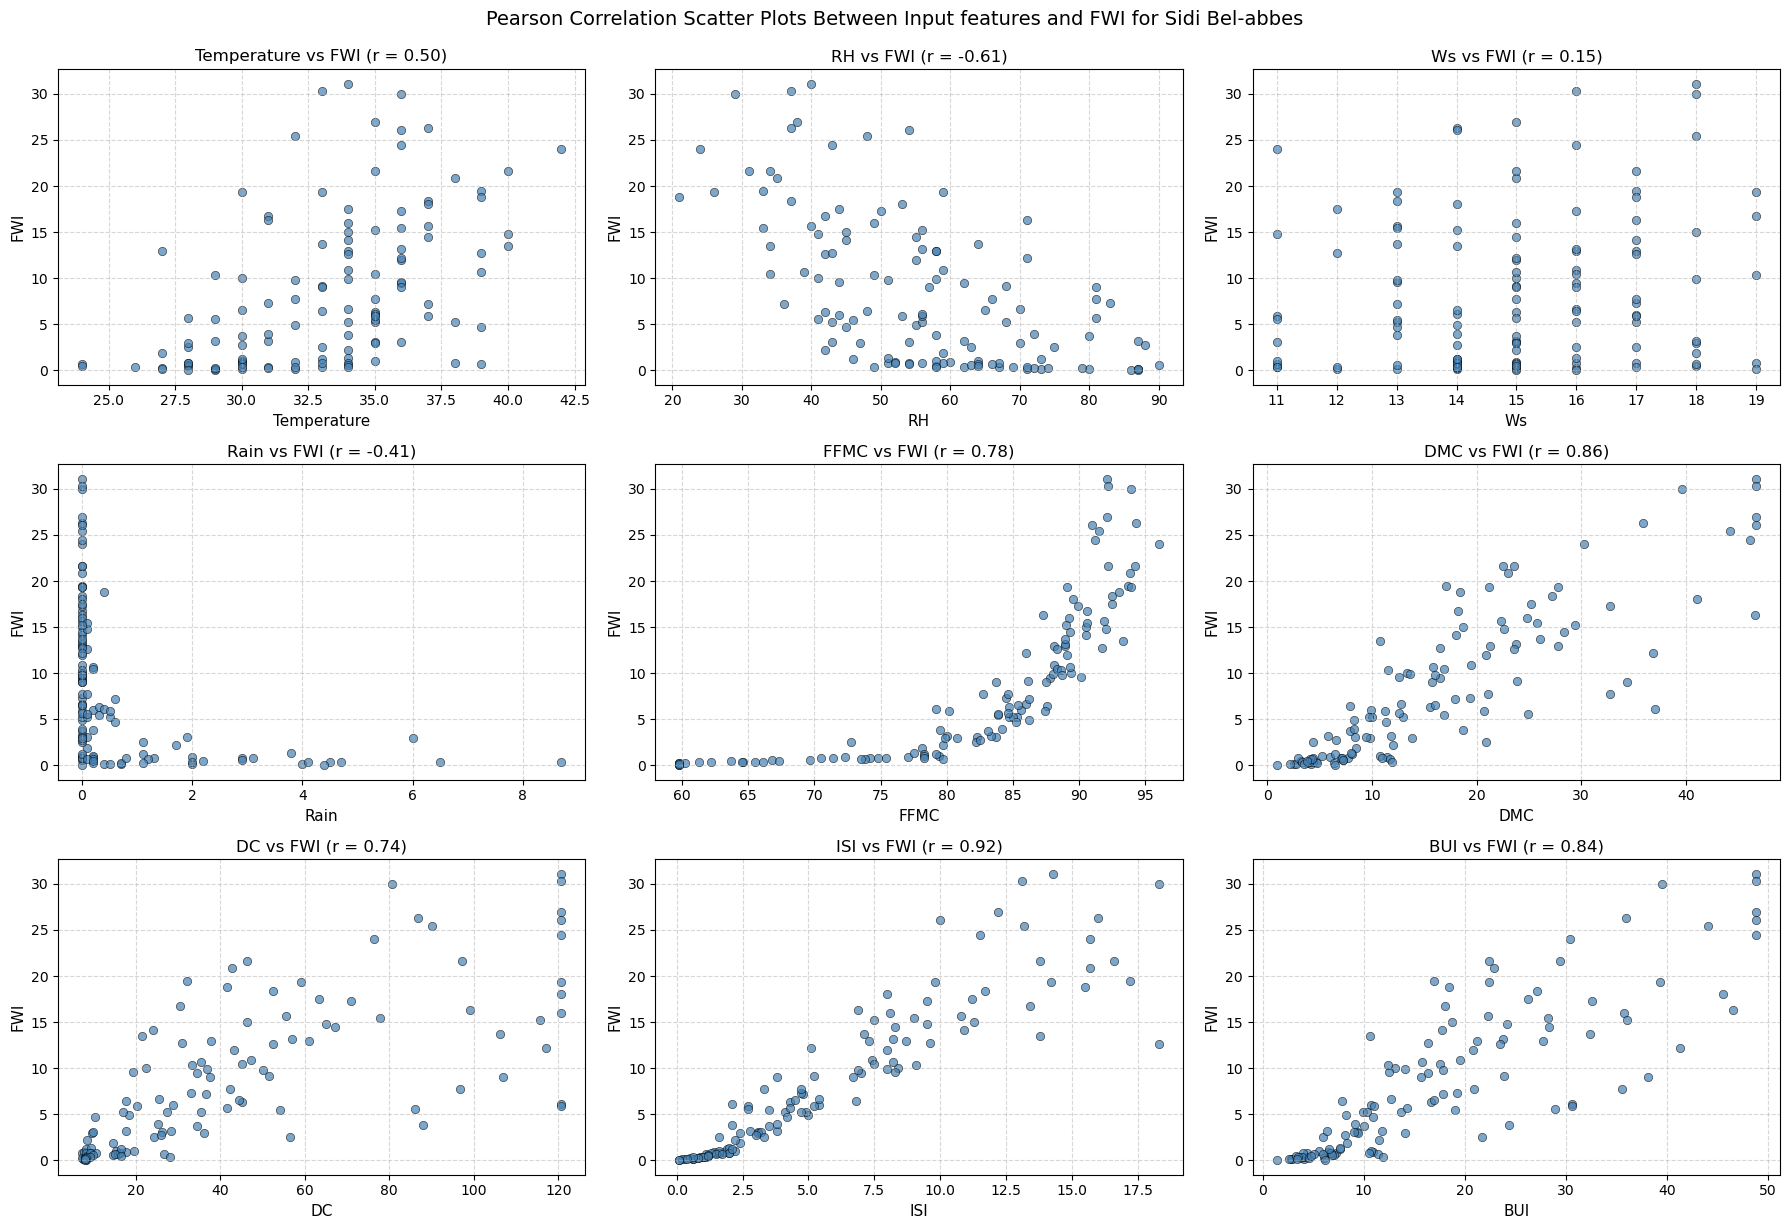

Pearson correlation coefficients for features and FWI:
Temperature: 0.501
RH: -0.606
Ws: 0.151
Rain: -0.410
FFMC: 0.780
DMC: 0.855
DC: 0.738
ISI: 0.919
BUI: 0.845


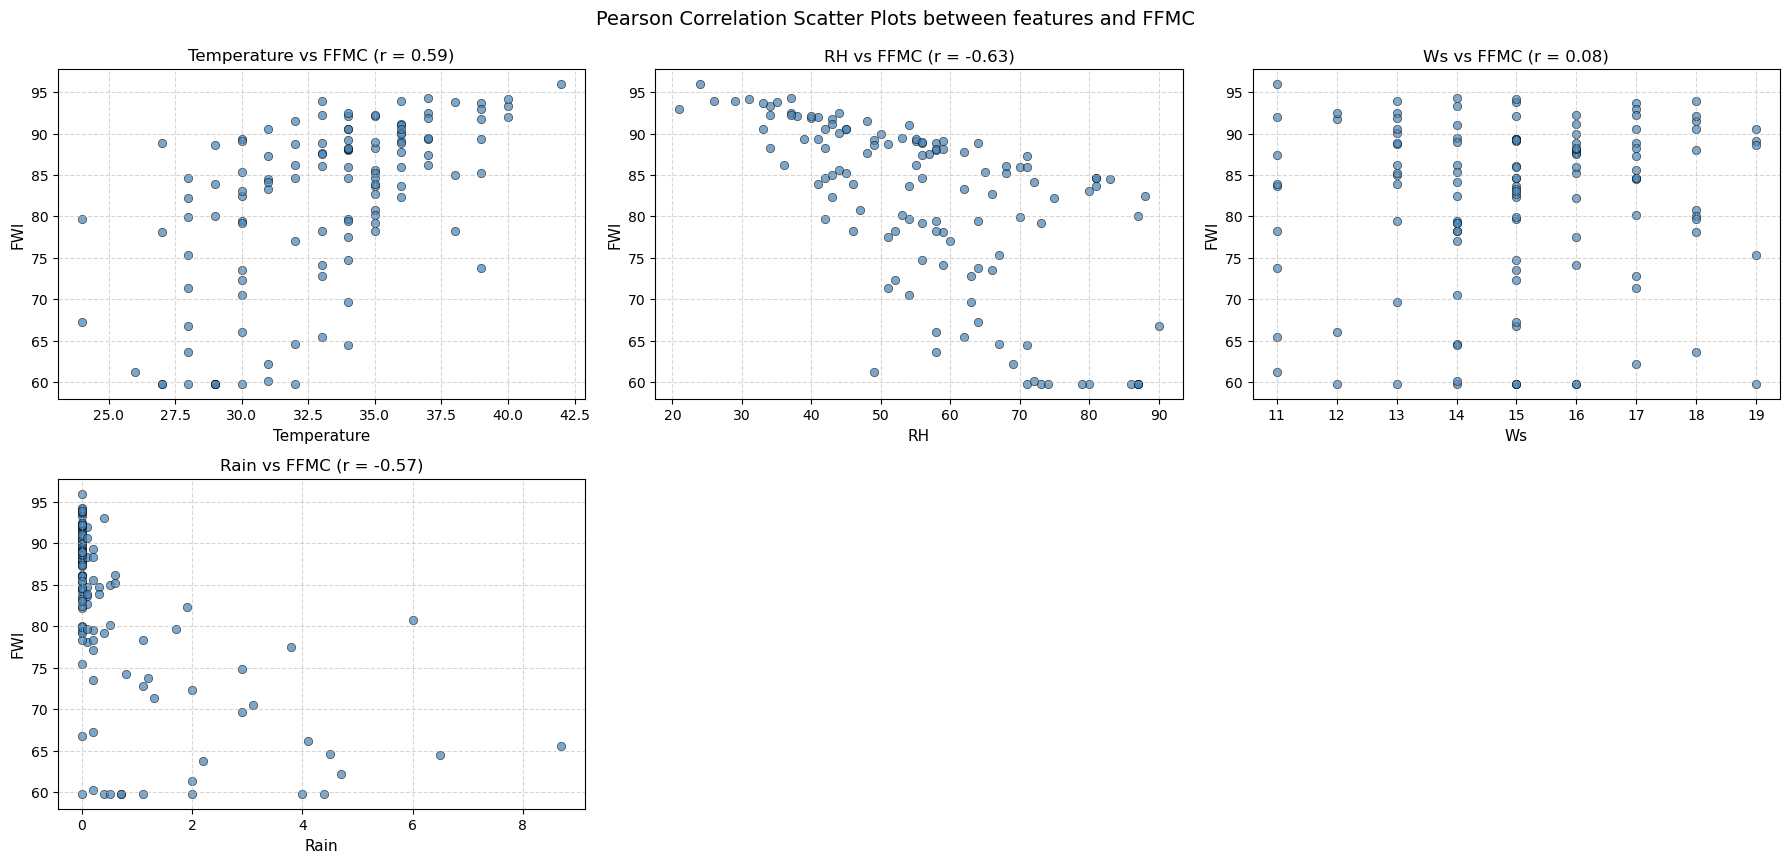

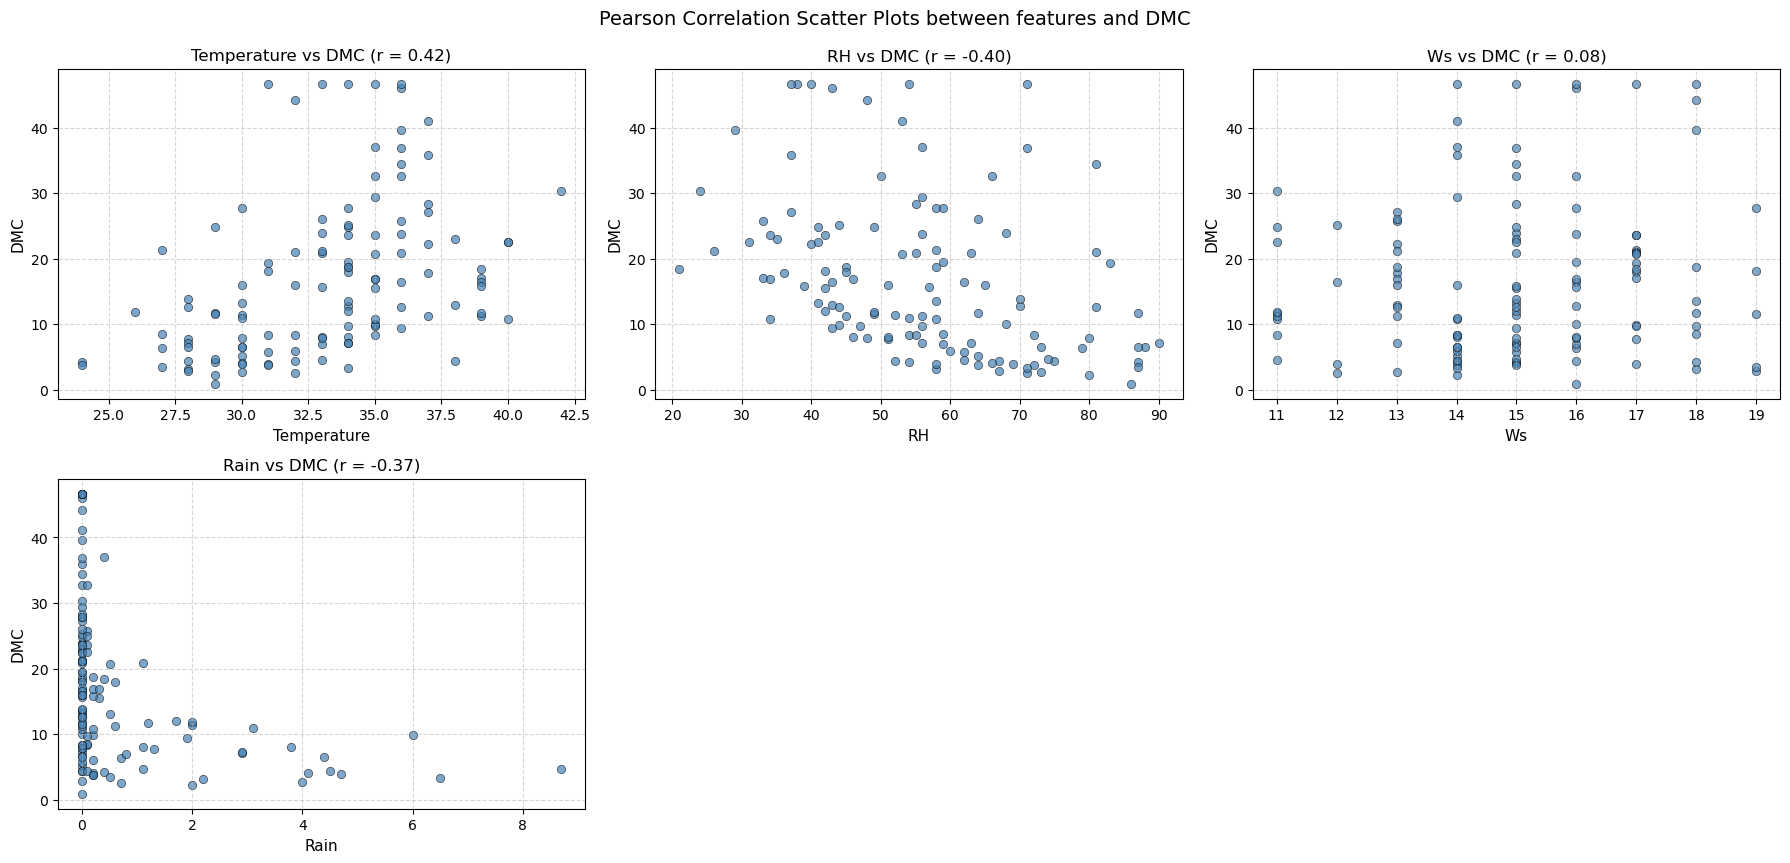

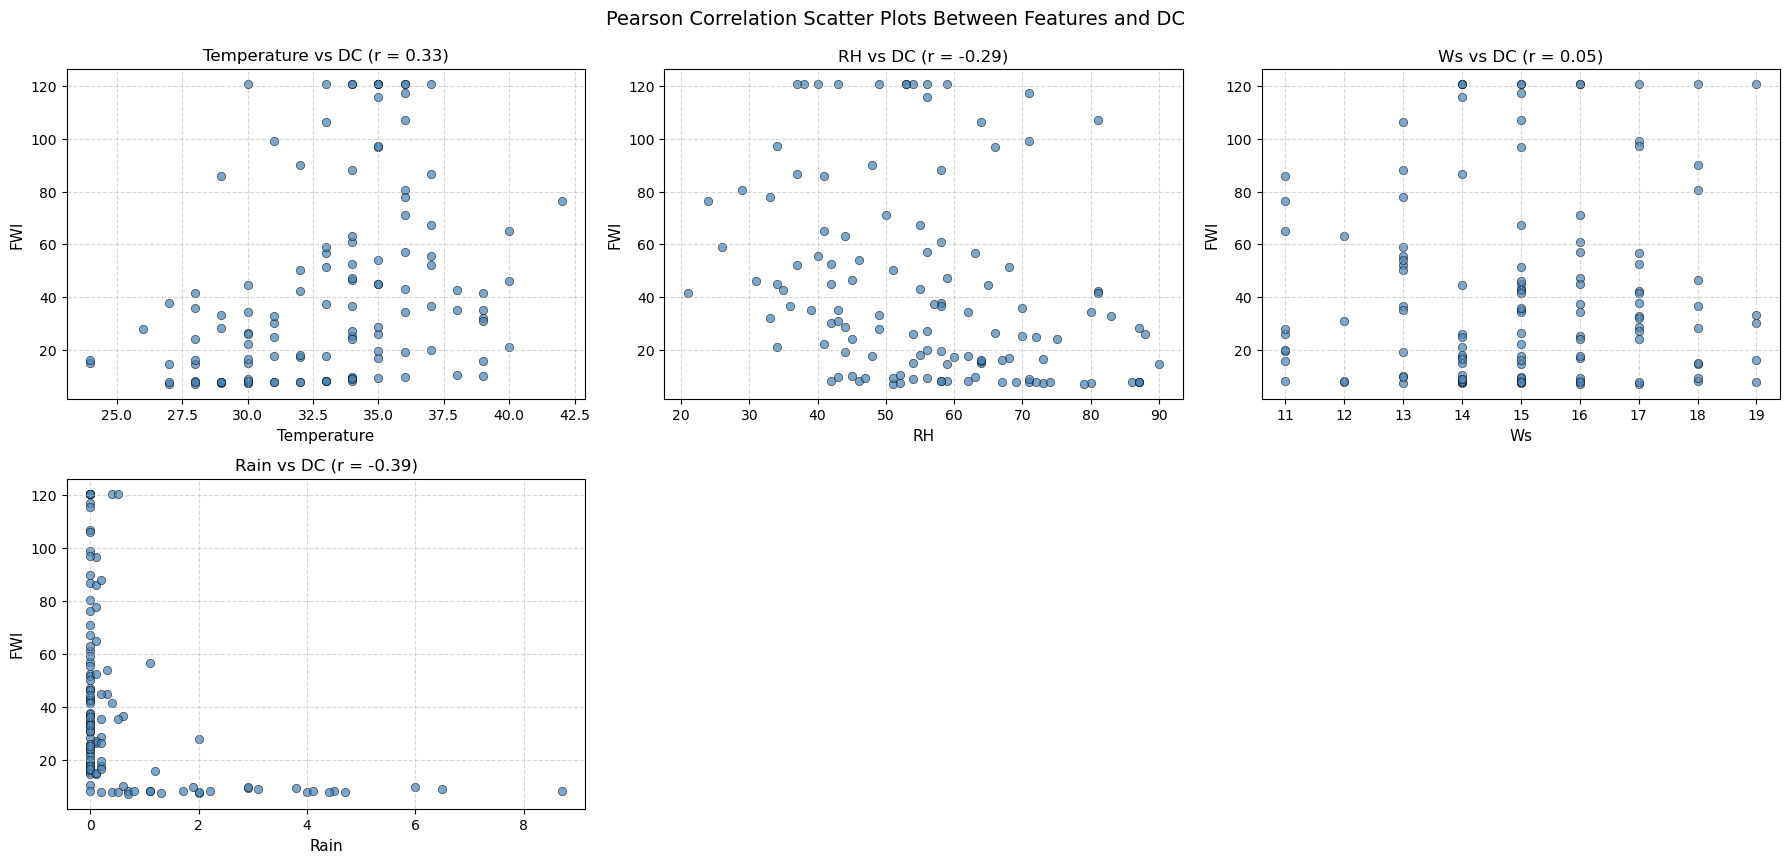

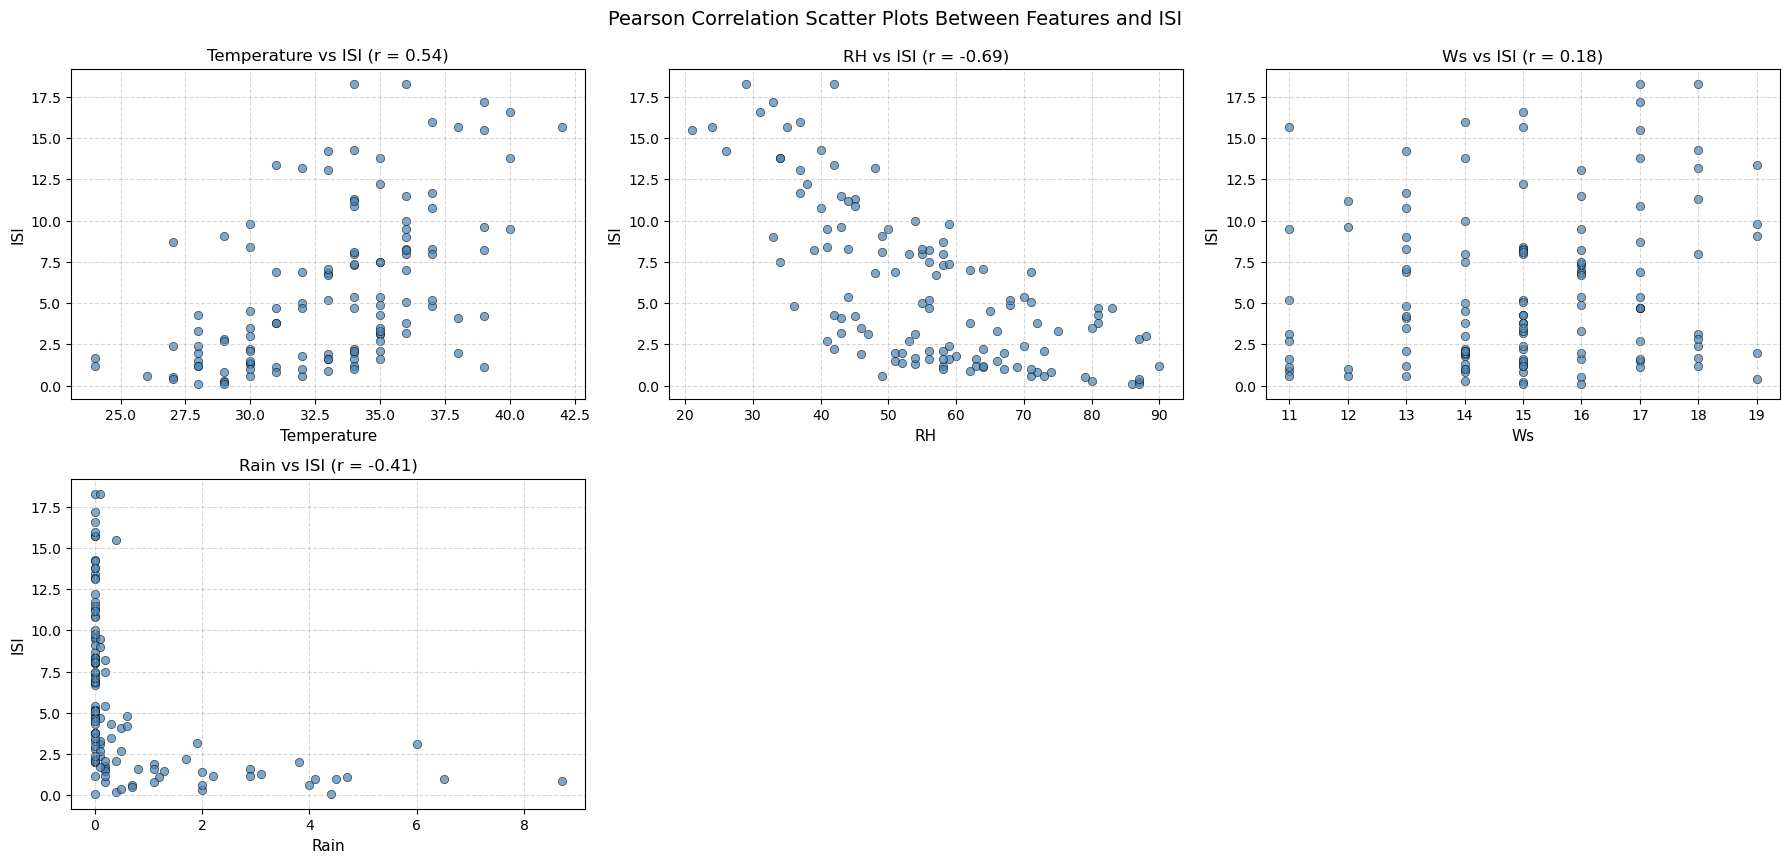

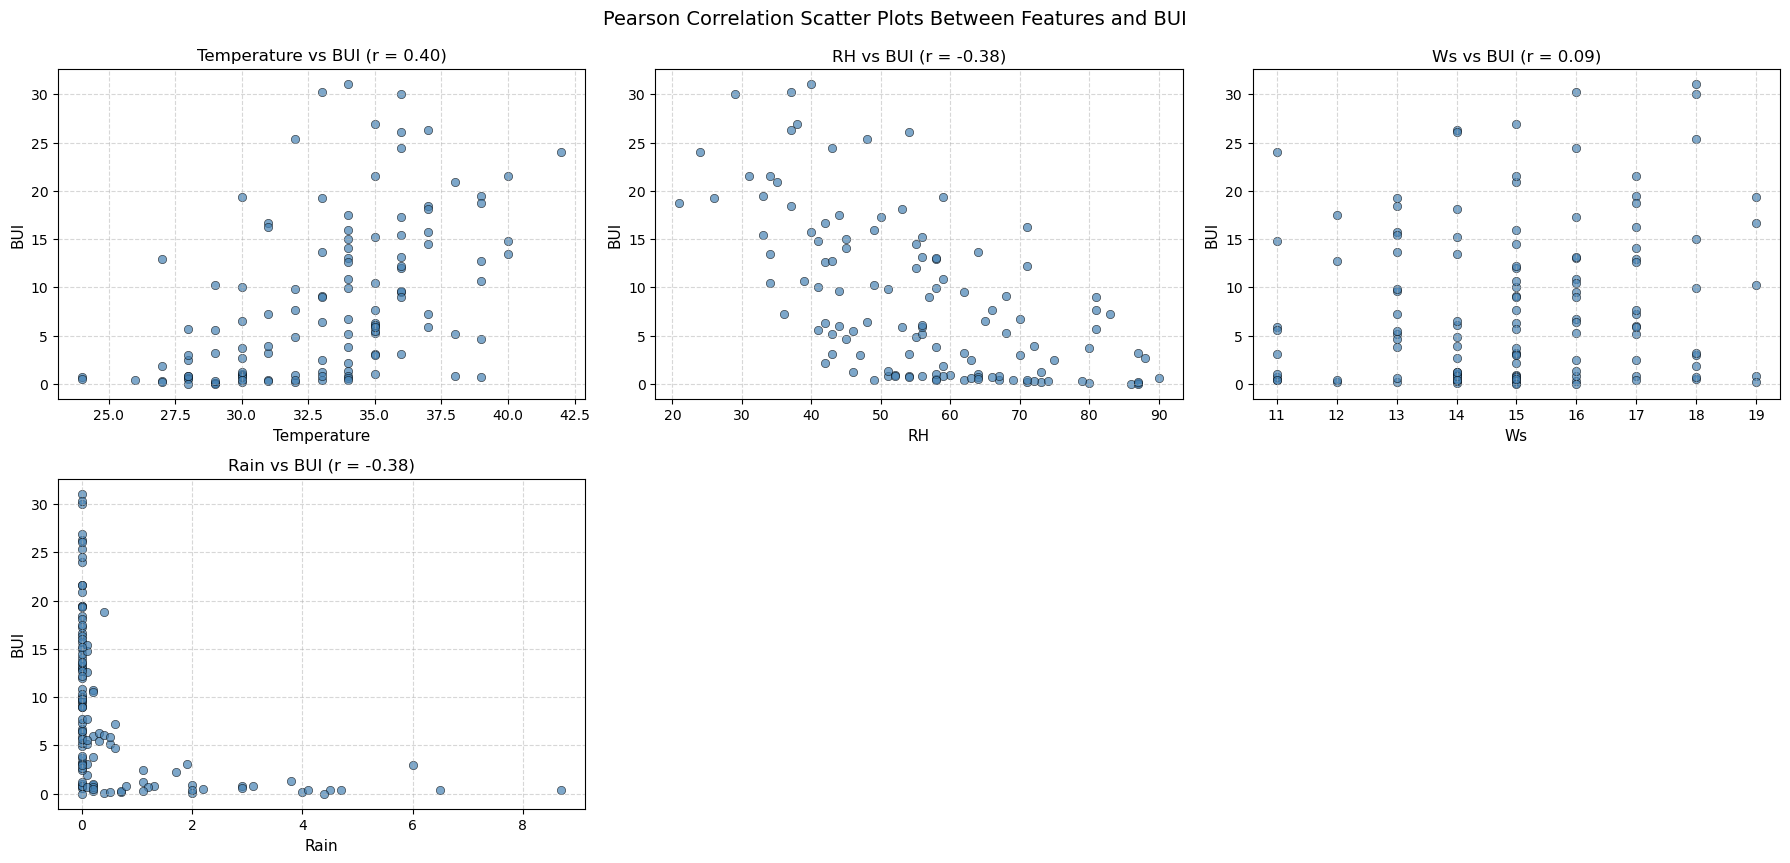

In [13]:
X = df[features]               
y = df['FWI']         

#applying pearson correlation matrix
def covariance(X, y):
    if len(X) != len(y):
       raise ValueError("X and Y must be the same length !")
    x_mean = np.mean(X)
    y_mean = np.mean(y)
    return sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(len(X))) / len(X)

def pearson_correlation(X, y):
    cov = covariance(X, y)
    std_dev_x = np.std(X)
    std_dev_y = np.std(y)
    if std_dev_x == 0 or std_dev_y == 0:
        return np.nan  # No correlation possible
    return cov / (std_dev_x * std_dev_y)

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[feature]) == 0 or np.std(df['FWI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[feature], df['FWI'])[0, 1]

    plt.title(f'{feature} vs FWI (r = {r:.2f})', fontsize=12)
    plt.xlabel(feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Input features and FWI for Sidi Bel-abbes", fontsize=14, y=1.02)
plt.show()

correlations = {}
for col in X.columns:
    correlations[col] = pearson_correlation(X[col].values, y.values)

print("Pearson correlation coefficients for features and FWI:")
for feature, r in correlations.items():
    print(f"{feature}: {r:.3f}")

#Pearson correlation for FFMC
weather_features = ["Temperature","RH","Ws","Rain"]
X = df[weather_features]               
y = df['FFMC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['FFMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['FFMC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['FFMC'])[0, 1]

    plt.title(f'{weather_feature} vs FFMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and FFMC", fontsize=14, y=1.02)
plt.show()

#Pearson correlation for DMC

X = df[weather_features]               
y = df['DMC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['DMC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['DMC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['DMC'])[0, 1]

    plt.title(f'{weather_feature} vs DMC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('DMC', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots between features and DMC", fontsize=14, y=1.02)
plt.show()

#pearson correlation for DC

X = df[weather_features]               
y = df['DC']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['DC'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['DC']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['DC'])[0, 1]

    plt.title(f'{weather_feature} vs DC (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('FWI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and DC", fontsize=14, y=1.02)
plt.show() 

#pearson correlation for ISI

X = df[weather_features]               
y = df['ISI']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['ISI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['ISI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['ISI'])[0, 1]

    plt.title(f'{weather_feature} vs ISI (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('ISI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and ISI", fontsize=14, y=1.02)
plt.show()

#pearson correlation for BUI

X = df[weather_features]               
y = df['BUI']

plt.figure(figsize=(18, 12))
for i, weather_feature in enumerate(weather_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(
        x=df[weather_feature],
        y=df['FWI'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    
    # Calculate correlation for each feature
    if np.std(df[weather_feature]) == 0 or np.std(df['BUI']) == 0:
        r = np.nan
    else:
        r = np.corrcoef(df[weather_feature], df['BUI'])[0, 1]

    plt.title(f'{weather_feature} vs BUI (r = {r:.2f})', fontsize=12)
    plt.xlabel(weather_feature, fontsize=11)
    plt.ylabel('BUI', fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Pearson Correlation Scatter Plots Between Features and BUI", fontsize=14, y=1.02)
plt.show()


#reference: https://medium.com/@shivogojohn/pearson-correlation-coefficient-in-python-74fb569f2b7f

**Model Development**

Model 1 - using all input features 

[I 2025-11-04 21:56:45,058] A new study created in memory with name: no-name-554eb239-ad94-41d9-b363-c1365e478ec9


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 21:56:45,103] Trial 0 finished with value: 0.7883229607584622 and parameters: {'learning_rate': 0.0819791724785241, 'max_depth': 5, 'subsample': 0.5098227374022637, 'colsample_bytree': 0.5247662138786844, 'lambda': 0.8311929292042722, 'alpha': 4.480091759837669}. Best is trial 0 with value: 0.7883229607584622.
[I 2025-11-04 21:56:45,163] Trial 1 finished with value: 2.5490891132657394 and parameters: {'learning_rate': 0.020310239709886622, 'max_depth': 5, 'subsample': 0.5280081741829179, 'colsample_bytree': 0.569154506986175, 'lambda': 3.9179528036415108, 'alpha': 1.0938649205912447}. Best is trial 0 with value: 0.7883229607584622.
[I 2025-11-04 21:56:45,201] Trial 2 finished with value: 1.0404405612019483 and parameters: {'learning_rate': 0.2790085695182113, 'max_depth': 7, 'subsample': 0.9006597132314548, 'colsample_bytree': 0.5157160952803791, 'lambda': 0.9626786511823583, 'alpha': 1.317060161073685}. Best is trial 0 with value: 0.7883229607584622.
[I 2025-11-04 21:56:

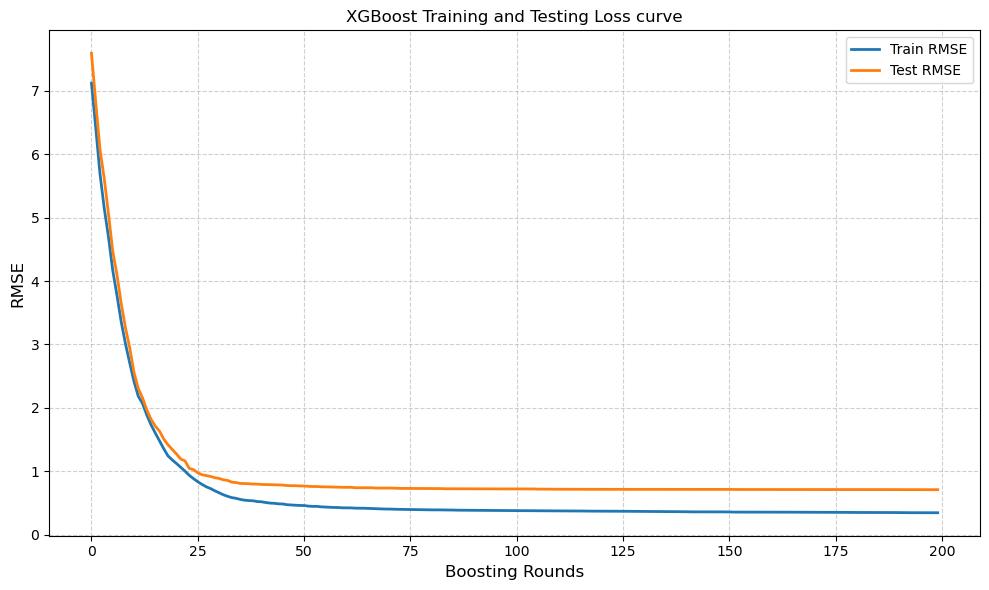

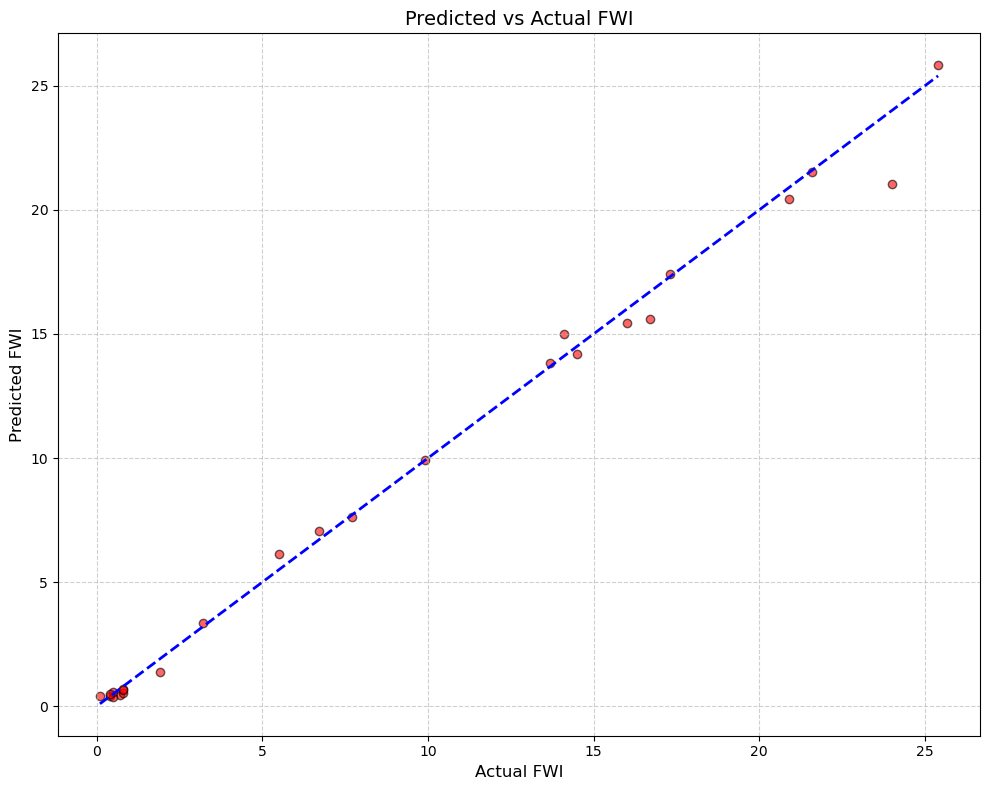

In [ ]:
features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"]
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 

xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial): #the hyperparameter tuning objective function is defined 
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100, #model is trained using the intially defined parameters
                      evals=[(xgb_test, 'test')],
                      verbose_eval=True)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)  #using optuna the best parameters are found 

#loss curve plotting
evals_result = {}
final_model = xgb.train(   #the final model is trained on the best parameters
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

preds = final_model.predict(xgb_test)   
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12) #loss curve is plotted
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2)  #Predicted VS Actual plot is plotted
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 


df_map = X_test.copy() 

df_map['FWI_pred'] = preds # Pivot table for heatmap
heatmap_data = df_map.pivot_table(index='Y', columns='X', values='FWI_pred', aggfunc='mean')

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Predicted FWI')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wildfire Risk Map (Predicted FWI)')
plt.show()

plt.scatter(df_map['X'], df_map['Y'], c=df_map['FWI_pred'], cmap='hot', edgecolor='k')
plt.colorbar(label='Predicted FWI')
plt.show() 

#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

XGBoost Model without hyperparameter tuning 

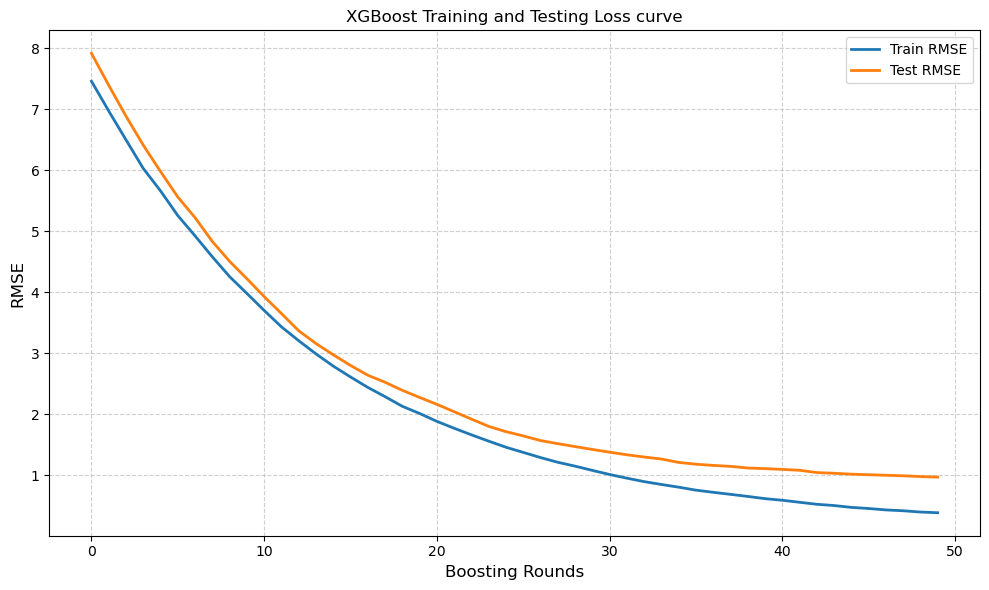

R² Score: 0.987
RMSE: 0.969
MAE: 0.569


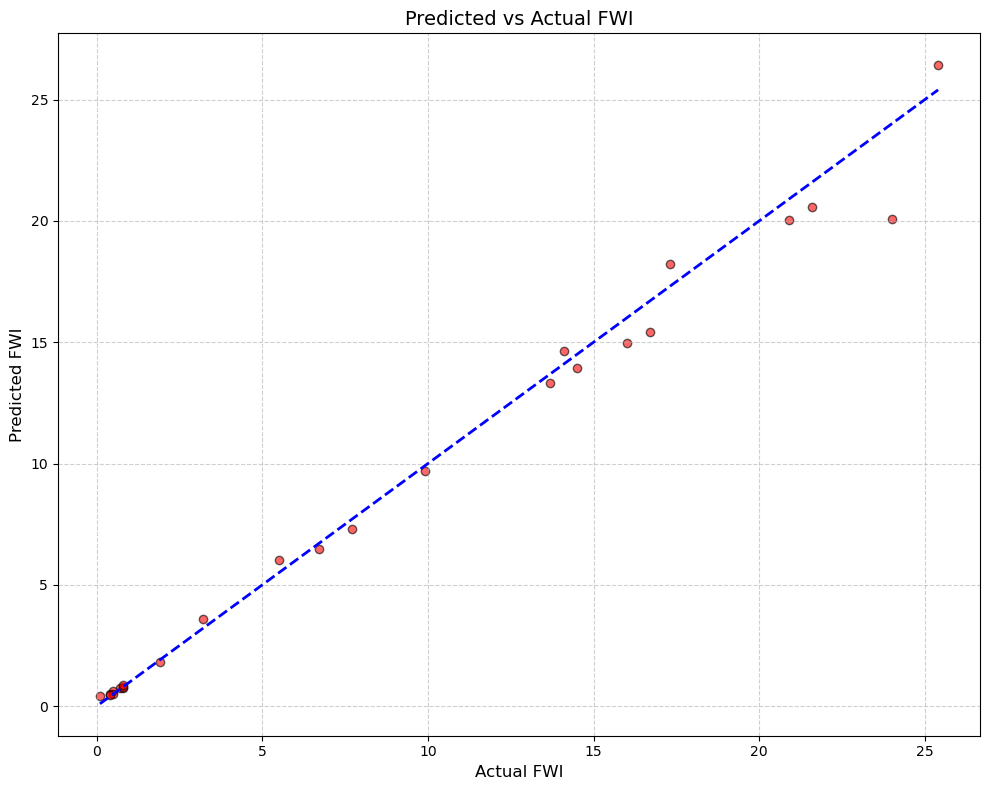

   day month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  FWI  \
0    1     6  2012           32  71  12   0.7  59.8  2.5   8.2  0.6  2.8  0.2   
1    2     6  2012           30  73  13   4.0  59.8  2.7   7.8  0.6  2.9  0.2   
2    3     6  2012           29  80  14   2.0  59.8  2.2   7.6  0.3  2.6  0.1   
3    4     6  2012           30  64  14   0.0  79.4  5.2  15.4  2.2  5.6  1.0   
4    5     6  2012           32  60  14   0.2  77.1  6.0  17.6  1.8  6.5  0.9   

   Classes  
0        0  
1        0  
2        0  
3        0  
4        0   



In [15]:

features = ["Temperature","RH","Ws", "Rain","FFMC","DMC","DC","ISI","BUI"]
target = 'FWI'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

xgb_train = xgb.DMatrix(X_train, y_train)
xgb_test = xgb.DMatrix(X_test, y_test)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.0835,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0.1,
    "seed": 42
}
n=50

evals_result = {}

model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n, evals=[(xgb_train, 'train'), (xgb_test, 'test')],evals_result=evals_result, verbose_eval=False)

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

preds = model.predict(xgb_test)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(df.head(), '\n') 


**Model 2 - Only weather data**

1) XGBoost

[I 2025-11-04 21:56:46,744] A new study created in memory with name: no-name-ea691413-9552-40b4-9413-13115802dd39


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 21:56:46,805] Trial 0 finished with value: 4.838040995827803 and parameters: {'learning_rate': 0.034475583506578075, 'max_depth': 5, 'subsample': 0.7877806487355039, 'colsample_bytree': 0.5914180292020008, 'lambda': 0.20162307669720372, 'alpha': 0.5916905090640401}. Best is trial 0 with value: 4.838040995827803.
[I 2025-11-04 21:56:46,831] Trial 1 finished with value: 3.8386306331122153 and parameters: {'learning_rate': 0.13628990773474847, 'max_depth': 3, 'subsample': 0.9175066601468109, 'colsample_bytree': 0.7878949284252771, 'lambda': 1.0334121907483038, 'alpha': 4.286285886453333}. Best is trial 1 with value: 3.8386306331122153.
[I 2025-11-04 21:56:46,888] Trial 2 finished with value: 4.028008013561212 and parameters: {'learning_rate': 0.2576137006593823, 'max_depth': 4, 'subsample': 0.5234167501096699, 'colsample_bytree': 0.8248532665957904, 'lambda': 4.849703000883834, 'alpha': 4.323019590730428}. Best is trial 1 with value: 3.8386306331122153.
[I 2025-11-04 21:56:4

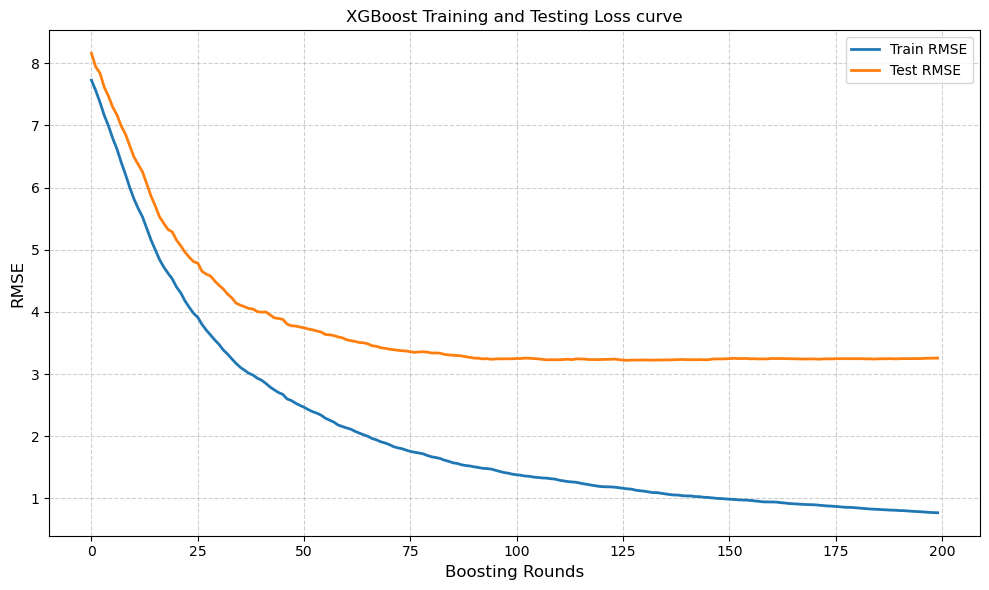

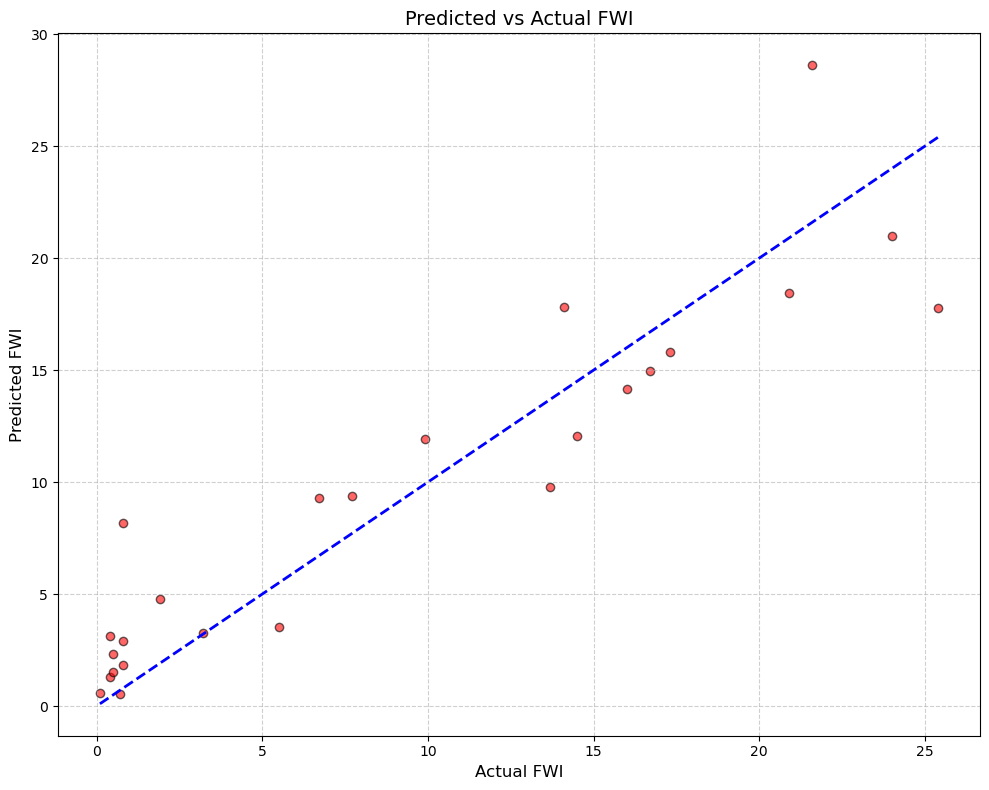

In [ ]:
features = ["Temperature","RH","Ws", "Rain","day"]
target = 'FWI'


X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0) #splits the dataset to 80% training and 20% testing 

xgb_train = xgb.DMatrix(X_train, y_train) #converts the inputs to a DMatrix object 
xgb_test = xgb.DMatrix(X_test, y_test)


def objective(trial): #the hyperparameter tuning objective function is defined 
    params = {
        "objective": "reg:squarederror",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 5),
        "alpha": trial.suggest_float("alpha", 1e-8, 5),
        "seed": 42
    }
    
    model = xgb.train(params=params, dtrain=xgb_train, num_boost_round=100, #model is trained using the intially defined parameters
                      evals=[(xgb_test, 'test')],
                      verbose_eval=True)
    
    preds = model.predict(xgb_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000, show_progress_bar=True)
best_params = study.best_params.copy()
best_params['objective'] = 'reg:squarederror'
best_params['seed'] = 42
print ("Best hyperparameters:", best_params)  #using optuna the best parameters are found 

#loss curve plotting
evals_result = {}
final_model = xgb.train(   #the final model is trained on the best parameters
    params=best_params,
    dtrain=xgb_train,
    num_boost_round=1000,
    evals=[(xgb_train, 'train'), (xgb_test, 'test')],
    evals_result=evals_result,
    verbose_eval=True
)

preds = final_model.predict(xgb_test)   
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.mean(np.abs((y_test - preds)))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

train_rmse_val = evals_result['train']['rmse']
test_rmse_val = evals_result['test']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_val, label='Train RMSE', linewidth=2)
plt.plot(test_rmse_val, label='Test RMSE', linewidth=2)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('XGBoost Training and Testing Loss curve', fontsize=12) #loss curve is plotted
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(y_test, preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2)  #Predicted VS Actual plot is plotted
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show() 


df_map = X_test.copy() 

df_map['FWI_pred'] = preds # Pivot table for heatmap
heatmap_data = df_map.pivot_table(index='Y', columns='X', values='FWI_pred', aggfunc='mean')

plt.figure(figsize=(8,6))
plt.imshow(heatmap_data, origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar(label='Predicted FWI')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Wildfire Risk Map (Predicted FWI)')
plt.show()

plt.scatter(df_map['X'], df_map['Y'], c=df_map['FWI_pred'], cmap='hot', edgecolor='k')
plt.colorbar(label='Predicted FWI')
plt.show() 

#reference: https://www.geeksforgeeks.org/machine-learning/implementation-of-xgboost-extreme-gradient-boosting/
#reference: https://xgboost.readthedocs.io/en/stable/python/examples/evals_result.html
#reference: hhttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/ttps://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/   (to confirm the shape of the learning curve)
#reference: https://github.com/ishandandekar/misc/blob/8711f9bcd8866ed3f220b2bf3f647993c6884283/xgboost_optuna.py#L15-L17

XGBoost Regressor

[I 2025-11-04 21:56:49,432] A new study created in memory with name: no-name-aa515738-a85a-4c10-958b-1916fce7d991
[I 2025-11-04 21:56:49,484] Trial 0 finished with value: 3.871528286279007 and parameters: {'n_estimators': 389, 'max_depth': 3, 'learning_rate': 0.09553528962882163, 'subsample': 0.9087167335893325, 'colsample_bytree': 0.7908971247489088, 'reg_lambda': 1.6052892447544889, 'reg_alpha': 2.3685142811916053}. Best is trial 0 with value: 3.871528286279007.
[I 2025-11-04 21:56:49,551] Trial 1 finished with value: 4.061432153925167 and parameters: {'n_estimators': 432, 'max_depth': 7, 'learning_rate': 0.15202005077915054, 'subsample': 0.8249774378968637, 'colsample_bytree': 0.9348454986339487, 'reg_lambda': 0.8637919013921793, 'reg_alpha': 0.8836838919009903}. Best is trial 0 with value: 3.871528286279007.
[I 2025-11-04 21:56:49,726] Trial 2 finished with value: 3.957335397332123 and parameters: {'n_estimators': 858, 'max_depth': 8, 'learning_rate': 0.008765851204915007, 'subsamp

XGBoost R²: 0.8173706925857589


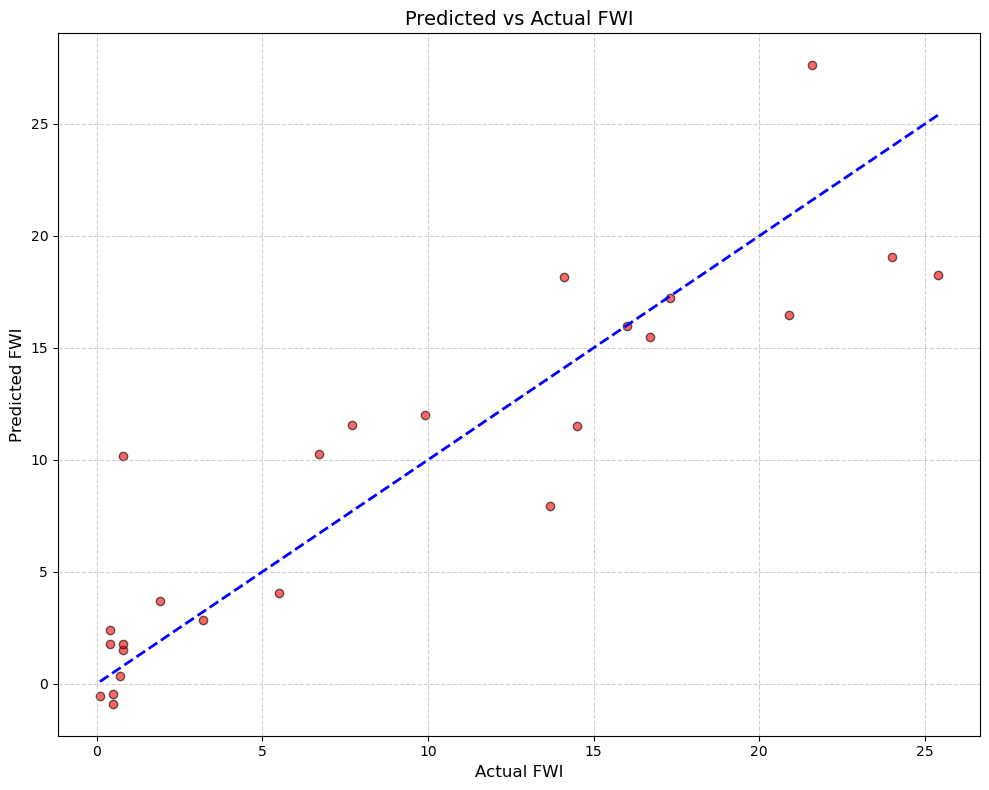

In [ ]:

features = ["Temperature","RH","Ws","Rain","day"]
target = "FWI"

X = df[features] #input features
y = df[target]  #target 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 


def xgb_objective(trial): #defines the objective function
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5),
        "random_state": 42
    }
    
    model = xgb.XGBRegressor(**params) #trains the model based on the above hyperparameters
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=30)
best_xgb_params = study_xgb.best_params
best_xgb_params['random_state'] = 42

xgb_model = xgb.XGBRegressor(**best_xgb_params) #finals model is trained on the best hyperaparmeters
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, xgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, xgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[I 2025-11-04 21:56:52,723] A new study created in memory with name: no-name-105e975b-9c02-4f1b-92f6-d3858c8b37f9
c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\VICTUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VICTUS\anaconda3\Lib\subprocess.py", line 1039, 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-04 21:56:52,816] Trial 1 finished with value: 3.9006478364274155 and parameters: {'n_estimators': 705, 'num_leaves': 177, 'max_depth': 9, 'learning_rate': 0.2405722890508352, 'subsample': 0.8707661007050498, 'colsample_bytree': 0.9358896458694165, 'reg_alpha': 2.930583793913027, 'reg_lambda': 2.771839499412898}. Best is trial 0 with value: 3.816930603073836.
[I 2025-11-04 21:56:52,847] Trial 2 finished with value: 3.9382566104640198 and parameters: {'n_estimators': 422, 'num_leaves': 116, 'max_depth': 5, 'learning_rate': 0.1021295947864081, 'subsample': 0.813798937372465, 'colsample_bytree': 0.8973166411992697, 'reg_alpha': 0.7656052736791952, 'reg_lambda': 0.30681320741645146}. Best is trial 0 with value: 3.816930603073836.
[I 2025-11-04 21:56:52,879] Trial 3 finished with value: 3.5515412302937897 and parameters: {'n_estimators': 479, 'num_leaves': 43, 'max_depth': 3, 'learning_rate': 0.042049951631583087, 'subsample': 0.6719352993067824, 'colsample_bytree': 0.739924869354

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2025-11-04 21:56:52,946] Trial 5 finished with value: 3.4632925162725376 and parameters: {'n_estimators': 370, 'num_leaves': 178, 'max_depth': 8, 'learning_rate': 0.01967107242413043, 'subsample': 0.8102245984752929, 'colsample_bytree': 0.8939821032953901, 'reg_alpha': 0.6164981235386036, 'reg_lambda': 0.1026856581959551}. Best is trial 5 with value: 3.4632925162725376.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:53,025] Trial 6 finished with value: 4.427199133244897 and parameters: {'n_estimators': 878, 'num_leaves': 83, 'max_depth': 3, 'learning_rate': 0.23425056431051636, 'subsample': 0.8942417439650441, 'colsample_bytree': 0.6647377472198804, 'reg_alpha': 0.7040557266075148, 'reg_lambda': 1.854892288797998}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,069] Trial 7 finished with value: 4.18828854226385 and parameters: {'n_estimators': 735, 'num_leaves': 74, 'max_depth': 14, 'learning_rate': 0.19663224191721465, 'subsample': 0.9101032004739973, 'colsample_bytree': 0.7247736540161157, 'reg_alpha': 1.4421650338120884, 'reg_lambda': 4.284902381828134}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,084] Trial 8 finished with value: 3.8919003131810994 and parameters: {'n_estimators': 138, 'num_leaves': 195, 'max_depth': 13, 'learning_rate': 0.262065822789359, 'subsample': 0.7188594778768906, 'colsample_bytree': 0.7695837288875

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:53,162] Trial 10 finished with value: 3.515054384413424 and parameters: {'n_estimators': 256, 'num_leaves': 150, 'max_depth': 10, 'learning_rate': 0.01695573343573817, 'subsample': 0.7746603612612966, 'colsample_bytree': 0.8394641587012688, 'reg_alpha': 1.8855329224724529, 'reg_lambda': 0.08884383453086568}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,190] Trial 11 finished with value: 4.000336352013161 and parameters: {'n_estimators': 237, 'num_leaves': 153, 'max_depth': 11, 'learning_rate': 0.010771866503961947, 'subsample': 0.7598624481492168, 'colsample_bytree': 0.8415795188212917, 'reg_alpha': 1.9881295989306544, 'reg_lambda': 0.09263091601974788}. Best is trial 5 with value: 3.4632925162725376.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:53,225] Trial 12 finished with value: 3.6260392749080284 and parameters: {'n_estimators': 343, 'num_leaves': 152, 'max_depth': 10, 'learning_rate': 0.010715003559128498, 'subsample': 0.6168556453570877, 'colsample_bytree': 0.8389620381734696, 'reg_alpha': 1.7233519271155653, 'reg_lambda': 1.0302054257234765}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,254] Trial 13 finished with value: 3.6014175589367565 and parameters: {'n_estimators': 293, 'num_leaves': 129, 'max_depth': 12, 'learning_rate': 0.12681215529704146, 'subsample': 0.8047096735750784, 'colsample_bytree': 0.8220696608655595, 'reg_alpha': 4.57422447266444, 'reg_lambda': 1.0808183346448283}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,275] Trial 14 finished with value: 3.6922309083209055 and parameters: {'n_estimators': 119, 'num_leaves': 172, 'max_depth': 8, 'learning_rate': 0.1778236546926273, 'subsample': 0.7720253555734923, 'colsample_bytree': 0.992

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:53,461] Trial 18 finished with value: 3.875400639686136 and parameters: {'n_estimators': 984, 'num_leaves': 199, 'max_depth': 11, 'learning_rate': 0.04971257361355988, 'subsample': 0.8483026730339192, 'colsample_bytree': 0.9541442227889536, 'reg_alpha': 1.1912299356899205, 'reg_lambda': 0.003439200699123568}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,493] Trial 19 finished with value: 3.494297804694126 and parameters: {'n_estimators': 216, 'num_leaves': 26, 'max_depth': 9, 'learning_rate': 0.03210092508908274, 'subsample': 0.6036365055478393, 'colsample_bytree': 0.8791130531077076, 'reg_alpha': 0.08909264835317743, 'reg_lambda': 1.3633175330951346}. Best is trial 5 with value: 3.4632925162725376.
[I 2025-11-04 21:56:53,528] Trial 20 finished with value: 3.605155468065324 and parameters: {'n_estimators': 364, 'num_leaves': 20, 'max_depth': 5, 'learning_rate': 0.07176125280954998, 'subsample': 0.6368252515998746, 'colsample_bytree': 0.8809

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:53,630] Trial 23 finished with value: 3.4291308346217573 and parameters: {'n_estimators': 106, 'num_leaves': 54, 'max_depth': 8, 'learning_rate': 0.061873430384745756, 'subsample': 0.6579910623390439, 'colsample_bytree': 0.800435619411926, 'reg_alpha': 1.1495919331816333, 'reg_lambda': 0.7310840172071366}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:53,653] Trial 24 finished with value: 3.4851690323091886 and parameters: {'n_estimators': 139, 'num_leaves': 64, 'max_depth': 8, 'learning_rate': 0.08629788154356396, 'subsample': 0.6328642269646305, 'colsample_bytree': 0.7305135435238, 'reg_alpha': 1.5348381859236788, 'reg_lambda': 0.6258358366291529}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:53,675] Trial 25 finished with value: 3.6610667184461634 and parameters: {'n_estimators': 105, 'num_leaves': 41, 'max_depth': 7, 'learning_rate': 0.060107824070733985, 'subsample': 0.7011710810774361, 'colsample_bytree': 0.6828249132

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:53,837] Trial 30 finished with value: 3.5422904257532983 and parameters: {'n_estimators': 294, 'num_leaves': 119, 'max_depth': 8, 'learning_rate': 0.05971274629119144, 'subsample': 0.6304030126725502, 'colsample_bytree': 0.8565486775731952, 'reg_alpha': 1.0314112344737776, 'reg_lambda': 2.9670783318258556}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:53,865] Trial 31 finished with value: 3.5067697406301623 and parameters: {'n_estimators': 197, 'num_leaves': 53, 'max_depth': 9, 'learning_rate': 0.03006351891680757, 'subsample': 0.6614970606223622, 'colsample_bytree': 0.8023044950805305, 'reg_alpha': 0.9527198399706562, 'reg_lambda': 0.5996288417143436}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:53,898] Trial 32 finished with value: 3.4585141964014223 and parameters: {'n_estimators': 284, 'num_leaves': 50, 'max_depth': 9, 'learning_rate': 0.02649353712033238, 'subsample': 0.6538802448320116, 'colsample_bytree': 0.7488106

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:54,041] Trial 36 finished with value: 3.4603913683990313 and parameters: {'n_estimators': 167, 'num_leaves': 90, 'max_depth': 10, 'learning_rate': 0.07073939402690653, 'subsample': 0.6824140738169977, 'colsample_bytree': 0.7118825482240563, 'reg_alpha': 3.2183180851410658, 'reg_lambda': 2.1463502660192644}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,095] Trial 37 finished with value: 3.5160104472769707 and parameters: {'n_estimators': 274, 'num_leaves': 105, 'max_depth': 4, 'learning_rate': 0.09928663180682609, 'subsample': 0.7086378277597137, 'colsample_bytree': 0.76024402878492, 'reg_alpha': 3.0615533673977118, 'reg_lambda': 2.6969393310251686}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,142] Trial 38 finished with value: 3.5888194069472843 and parameters: {'n_estimators': 618, 'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.04726807779075452, 'subsample': 0.677750484123294, 'colsample_bytree': 0.783514102

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:54,253] Trial 41 finished with value: 3.4344160330302156 and parameters: {'n_estimators': 177, 'num_leaves': 96, 'max_depth': 10, 'learning_rate': 0.06742064533366385, 'subsample': 0.6831922957581562, 'colsample_bytree': 0.7087200974742048, 'reg_alpha': 3.283462113814574, 'reg_lambda': 2.166912181621459}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,286] Trial 42 finished with value: 3.4791923828872355 and parameters: {'n_estimators': 161, 'num_leaves': 97, 'max_depth': 12, 'learning_rate': 0.040607965840924576, 'subsample': 0.6478638535512757, 'colsample_bytree': 0.7495527961979774, 'reg_alpha': 3.2900694301586317, 'reg_lambda': 3.5067542859717484}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,322] Trial 43 finished with value: 3.492680906896668 and parameters: {'n_estimators': 260, 'num_leaves': 30, 'max_depth': 10, 'learning_rate': 0.06520070083512144, 'subsample': 0.6900835533213711, 'colsample_bytree': 0.7898242

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:54,470] Trial 46 finished with value: 3.667791375839029 and parameters: {'n_estimators': 610, 'num_leaves': 107, 'max_depth': 8, 'learning_rate': 0.04017858994190786, 'subsample': 0.7587951726726251, 'colsample_bytree': 0.6590524905250014, 'reg_alpha': 3.6200057239034287, 'reg_lambda': 1.9068322728230918}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,560] Trial 47 finished with value: 3.606102471912876 and parameters: {'n_estimators': 532, 'num_leaves': 130, 'max_depth': 8, 'learning_rate': 0.11952444903545212, 'subsample': 0.6115326301248218, 'colsample_bytree': 0.8248545884015404, 'reg_alpha': 4.33354536440753, 'reg_lambda': 3.172650849627958}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,619] Trial 48 finished with value: 3.731636174488034 and parameters: {'n_estimators': 668, 'num_leaves': 77, 'max_depth': 12, 'learning_rate': 0.1622249766440553, 'subsample': 0.7227410961027568, 'colsample_bytree': 0.715971313118

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:54,673] Trial 49 finished with value: 3.531636560992548 and parameters: {'n_estimators': 445, 'num_leaves': 99, 'max_depth': 11, 'learning_rate': 0.09401371673079079, 'subsample': 0.7869814418760218, 'colsample_bytree': 0.7348396085640446, 'reg_alpha': 3.8627204845480856, 'reg_lambda': 2.388589135542906}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,766] Trial 50 finished with value: 3.810233085951598 and parameters: {'n_estimators': 783, 'num_leaves': 114, 'max_depth': 7, 'learning_rate': 0.07379308165820217, 'subsample': 0.6702324442560067, 'colsample_bytree': 0.7622748521980102, 'reg_alpha': 2.54976781023113, 'reg_lambda': 2.1919761244529576}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,816] Trial 51 finished with value: 3.4420980126697676 and parameters: {'n_estimators': 319, 'num_leaves': 67, 'max_depth': 9, 'learning_rate': 0.020473335432755705, 'subsample': 0.6499681296458625, 'colsample_bytree': 0.7501324880

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:54,902] Trial 52 finished with value: 3.4377967632659145 and parameters: {'n_estimators': 320, 'num_leaves': 67, 'max_depth': 10, 'learning_rate': 0.023435789873050745, 'subsample': 0.6412054460461706, 'colsample_bytree': 0.703320556038485, 'reg_alpha': 1.9045516889239171, 'reg_lambda': 1.0850278893314447}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:54,957] Trial 53 finished with value: 3.514720205833692 and parameters: {'n_estimators': 329, 'num_leaves': 66, 'max_depth': 10, 'learning_rate': 0.045200467403338905, 'subsample': 0.6214339458689829, 'colsample_bytree': 0.8206963278446414, 'reg_alpha': 1.8867491073626699, 'reg_lambda': 4.854111958733494}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,003] Trial 54 finished with value: 3.579028351911307 and parameters: {'n_estimators': 209, 'num_leaves': 79, 'max_depth': 11, 'learning_rate': 0.021090255456297457, 'subsample': 0.6363897466666096, 'colsample_bytree': 0.670212

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-11-04 21:56:55,080] Trial 56 finished with value: 3.450350867375256 and parameters: {'n_estimators': 246, 'num_leaves': 92, 'max_depth': 9, 'learning_rate': 0.03851628862764021, 'subsample': 0.646956891119756, 'colsample_bytree': 0.7847404545597052, 'reg_alpha': 0.7005697132923757, 'reg_lambda': 0.23733654786160369}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,120] Trial 57 finished with value: 3.6726725724864493 and parameters: {'n_estimators': 201, 'num_leaves': 70, 'max_depth': 8, 'learning_rate': 0.019879924367449037, 'subsample': 0.6001842516546961, 'colsample_bytree': 0.6996756262949646, 'reg_alpha': 2.4684879913536935, 'reg_lambda': 1.0745537274336783}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,173] Trial 58 finished with value: 3.644154394919227 and parameters: {'n_estimators': 373, 'num_leaves': 44, 'max_depth': 13, 'learning_rate': 0.07439449629426775, 'subsample': 0.6687670571901138, 'colsample_bytree': 0.73376572

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:55,307] Trial 61 finished with value: 3.4598295036880753 and parameters: {'n_estimators': 235, 'num_leaves': 87, 'max_depth': 9, 'learning_rate': 0.03625928850896047, 'subsample': 0.6431056372172602, 'colsample_bytree': 0.7947948779748872, 'reg_alpha': 0.7727910039603476, 'reg_lambda': 0.1799339628465333}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,400] Trial 62 finished with value: 3.498473921367066 and parameters: {'n_estimators': 321, 'num_leaves': 95, 'max_depth': 9, 'learning_rate': 0.03874898587838549, 'subsample': 0.6603347852750248, 'colsample_bytree': 0.7800127962112469, 'reg_alpha': 0.6829345473270829, 'reg_lambda': 0.4171195256462169}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,439] Trial 63 finished with value: 3.4675683485052637 and parameters: {'n_estimators': 296, 'num_leaves': 91, 'max_depth': 10, 'learning_rate': 0.023666059923868027, 'subsample': 0.6813229871409602, 'colsample_bytree': 0.8519222

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:55,569] Trial 67 finished with value: 3.458959455246037 and parameters: {'n_estimators': 195, 'num_leaves': 82, 'max_depth': 12, 'learning_rate': 0.0789498679952092, 'subsample': 0.6599237338072359, 'colsample_bytree': 0.7256781445734697, 'reg_alpha': 2.064574806915651, 'reg_lambda': 1.4944427630837436}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,596] Trial 68 finished with value: 3.678646714778013 and parameters: {'n_estimators': 100, 'num_leaves': 65, 'max_depth': 11, 'learning_rate': 0.1487618123528998, 'subsample': 0.6124696677804841, 'colsample_bytree': 0.7423652302088709, 'reg_alpha': 1.2298124636995298, 'reg_lambda': 0.4315841159665988}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,629] Trial 69 finished with value: 3.7010033843571013 and parameters: {'n_estimators': 185, 'num_leaves': 109, 'max_depth': 13, 'learning_rate': 0.10662319523283041, 'subsample': 0.6980486087485331, 'colsample_bytree': 0.674949528

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:55,823] Trial 73 finished with value: 3.5294547149282836 and parameters: {'n_estimators': 304, 'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.04722032948696157, 'subsample': 0.6512373455306233, 'colsample_bytree': 0.7986078256520722, 'reg_alpha': 1.4852363768013859, 'reg_lambda': 0.4993466764227156}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,866] Trial 74 finished with value: 3.794322470494295 and parameters: {'n_estimators': 218, 'num_leaves': 112, 'max_depth': 8, 'learning_rate': 0.2354653917457915, 'subsample': 0.6269722334690065, 'colsample_bytree': 0.773338611177362, 'reg_alpha': 1.134440344112821, 'reg_lambda': 0.9975108258029186}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:55,901] Trial 75 finished with value: 3.6320919224506882 and parameters: {'n_estimators': 273, 'num_leaves': 84, 'max_depth': 8, 'learning_rate': 0.09226718215219822, 'subsample': 0.8668488159316681, 'colsample_bytree': 0.83051021571

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:55,976] Trial 77 finished with value: 4.194367886978763 and parameters: {'n_estimators': 222, 'num_leaves': 47, 'max_depth': 10, 'learning_rate': 0.010275055848989034, 'subsample': 0.6088387965516355, 'colsample_bytree': 0.8139488946459393, 'reg_alpha': 1.6143540528916889, 'reg_lambda': 1.1956061634742667}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,069] Trial 78 finished with value: 3.545509202242057 and parameters: {'n_estimators': 348, 'num_leaves': 78, 'max_depth': 9, 'learning_rate': 0.08121044818249405, 'subsample': 0.6869951740140156, 'colsample_bytree': 0.8464340907844493, 'reg_alpha': 0.8520413162973601, 'reg_lambda': 0.6561992265331351}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,119] Trial 79 finished with value: 3.9462440321405508 and parameters: {'n_estimators': 151, 'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.25351062093754323, 'subsample': 0.6406526030228992, 'colsample_bytree': 0.75829521

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-11-04 21:56:56,245] Trial 81 finished with value: 3.4717121549789938 and parameters: {'n_estimators': 237, 'num_leaves': 96, 'max_depth': 9, 'learning_rate': 0.040377283505579994, 'subsample': 0.6478695517940687, 'colsample_bytree': 0.7881379891969063, 'reg_alpha': 0.5865924738492463, 'reg_lambda': 0.302572063621742}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,312] Trial 82 finished with value: 3.4959789886259194 and parameters: {'n_estimators': 257, 'num_leaves': 92, 'max_depth': 10, 'learning_rate': 0.054424018224951215, 'subsample': 0.654427017914339, 'colsample_bytree': 0.795198740675262, 'reg_alpha': 0.36469197561971706, 'reg_lambda': 0.23267015294384097}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,356] Trial 83 finished with value: 3.5088343783734413 and parameters: {'n_estimators': 121, 'num_leaves': 100, 'max_depth': 7, 'learning_rate': 0.045231303268449645, 'subsample': 0.6205785381744494, 'colsample_bytree': 0.7811

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:56,431] Trial 84 finished with value: 3.449503090515551 and parameters: {'n_estimators': 277, 'num_leaves': 73, 'max_depth': 9, 'learning_rate': 0.035939705691586166, 'subsample': 0.6740662444379534, 'colsample_bytree': 0.754708722940143, 'reg_alpha': 3.465547624778322, 'reg_lambda': 0.40146937065167876}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,490] Trial 85 finished with value: 3.5238651324431722 and parameters: {'n_estimators': 280, 'num_leaves': 72, 'max_depth': 8, 'learning_rate': 0.06727839510059519, 'subsample': 0.682715007411179, 'colsample_bytree': 0.7450074777339991, 'reg_alpha': 3.3679687711142496, 'reg_lambda': 1.5775512156492866}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,560] Trial 86 finished with value: 3.78051577618587 and parameters: {'n_estimators': 179, 'num_leaves': 66, 'max_depth': 9, 'learning_rate': 0.018050029801055543, 'subsample': 0.7055476219215763, 'colsample_bytree': 0.75474940640

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:56,663] Trial 88 finished with value: 3.507922131937301 and parameters: {'n_estimators': 206, 'num_leaves': 84, 'max_depth': 9, 'learning_rate': 0.05943064494515697, 'subsample': 0.7223281919142284, 'colsample_bytree': 0.7733200077035306, 'reg_alpha': 2.360981799792469, 'reg_lambda': 1.766629527890981}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,696] Trial 89 finished with value: 3.529798360087501 and parameters: {'n_estimators': 160, 'num_leaves': 62, 'max_depth': 10, 'learning_rate': 0.033421178102453174, 'subsample': 0.663979471978739, 'colsample_bytree': 0.8156696122172667, 'reg_alpha': 3.1775862433290714, 'reg_lambda': 1.0045620518096852}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:56,734] Trial 90 finished with value: 3.7717455634935355 and parameters: {'n_estimators': 342, 'num_leaves': 36, 'max_depth': 6, 'learning_rate': 0.2131923279813122, 'subsample': 0.6293368982928712, 'colsample_bytree': 0.707558314066

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:56,919] Trial 94 finished with value: 3.508770995162584 and parameters: {'n_estimators': 220, 'num_leaves': 92, 'max_depth': 9, 'learning_rate': 0.018060377893118675, 'subsample': 0.6716577467885935, 'colsample_bytree': 0.7784965851224497, 'reg_alpha': 0.6406083985124571, 'reg_lambda': 0.928372339588151}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:57,037] Trial 95 finished with value: 3.826372625491437 and parameters: {'n_estimators': 945, 'num_leaves': 74, 'max_depth': 8, 'learning_rate': 0.05283009088416844, 'subsample': 0.6948263340564511, 'colsample_bytree': 0.8023961147690238, 'reg_alpha': 1.0577988647703174, 'reg_lambda': 0.8053413029286582}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:57,067] Trial 96 finished with value: 3.5340264797819696 and parameters: {'n_estimators': 183, 'num_leaves': 55, 'max_depth': 10, 'learning_rate': 0.027380507030447858, 'subsample': 0.63181513546321, 'colsample_bytree': 0.6838701224

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-11-04 21:56:57,110] Trial 97 finished with value: 3.4853717576168433 and parameters: {'n_estimators': 387, 'num_leaves': 43, 'max_depth': 8, 'learning_rate': 0.036854954282182564, 'subsample': 0.6064867993123843, 'colsample_bytree': 0.7867816859768456, 'reg_alpha': 1.8527978908367535, 'reg_lambda': 0.20480165781862386}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:57,140] Trial 98 finished with value: 3.477118542650799 and parameters: {'n_estimators': 123, 'num_leaves': 86, 'max_depth': 15, 'learning_rate': 0.07116435986128536, 'subsample': 0.6613302025569001, 'colsample_bytree': 0.7508810436907712, 'reg_alpha': 3.478707725633648, 'reg_lambda': 2.899725643554604}. Best is trial 22 with value: 3.40503698307044.
[I 2025-11-04 21:56:57,174] Trial 99 finished with value: 3.5971190168185116 and parameters: {'n_estimators': 245, 'num_leaves': 67, 'max_depth': 7, 'learning_rate': 0.015447084791875364, 'subsample': 0.6177489092114489, 'colsample_bytree': 0.8111043

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 5
[LightGBM] [Info] Start training from score 8.385417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

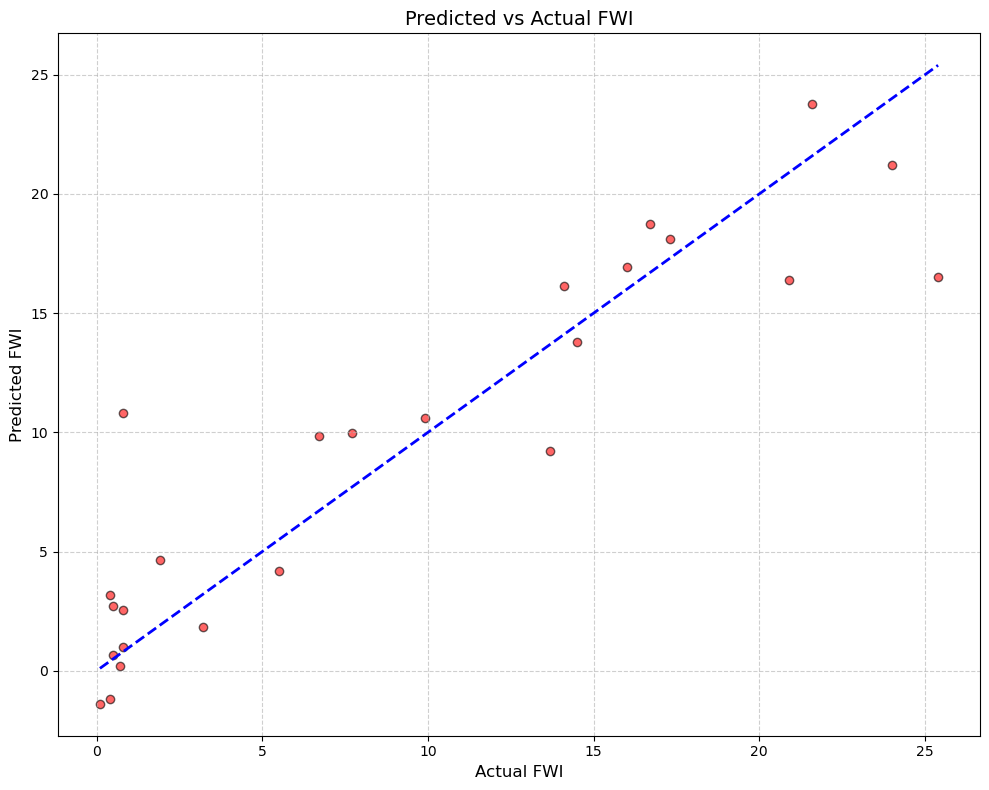

In [ ]:

def lgb_objective(trial): #objective function is defined for hyperparameter tuning 
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=False),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": 42
    }
    
    model = lgb.LGBMRegressor(**params)  #initially the model is trained for the above sample hyperparameters
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_lgb = optuna.create_study(direction='minimize') # the hyperparameter optimisation is run for 100 trials
study_lgb.optimize(lgb_objective, n_trials=100)
best_lgb_params = study_lgb.best_params
best_lgb_params['random_state'] = 42

lgb_model = lgb.LGBMRegressor(**best_lgb_params) #the best hyperparameters and the used to train the final Light GBM model
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("LightGBM R²:", r2_score(y_test, lgb_preds))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, lgb_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://forecastegy.com/posts/how-to-use-optuna-to-tune-lightgbm-hyperparameters/


[I 2025-11-04 21:56:57,334] A new study created in memory with name: no-name-11625003-b182-4ab7-9ad4-b963b4efb318
[I 2025-11-04 21:56:57,890] Trial 0 finished with value: 3.6956213967705103 and parameters: {'n_estimators': 499, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 3.6956213967705103.
[I 2025-11-04 21:56:58,528] Trial 1 finished with value: 3.775605899481135 and parameters: {'n_estimators': 616, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 3.6956213967705103.
[I 2025-11-04 21:56:59,337] Trial 2 finished with value: 4.285623014265225 and parameters: {'n_estimators': 812, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 0 with value: 3.6956213967705103.
[I 2025-11-04 21:56:59,569] Trial 3 finished with value: 4.207701487666847 and parameters: {'n_estimators': 202, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 0 with value:

Random Forest R²: 0.8129217225411307


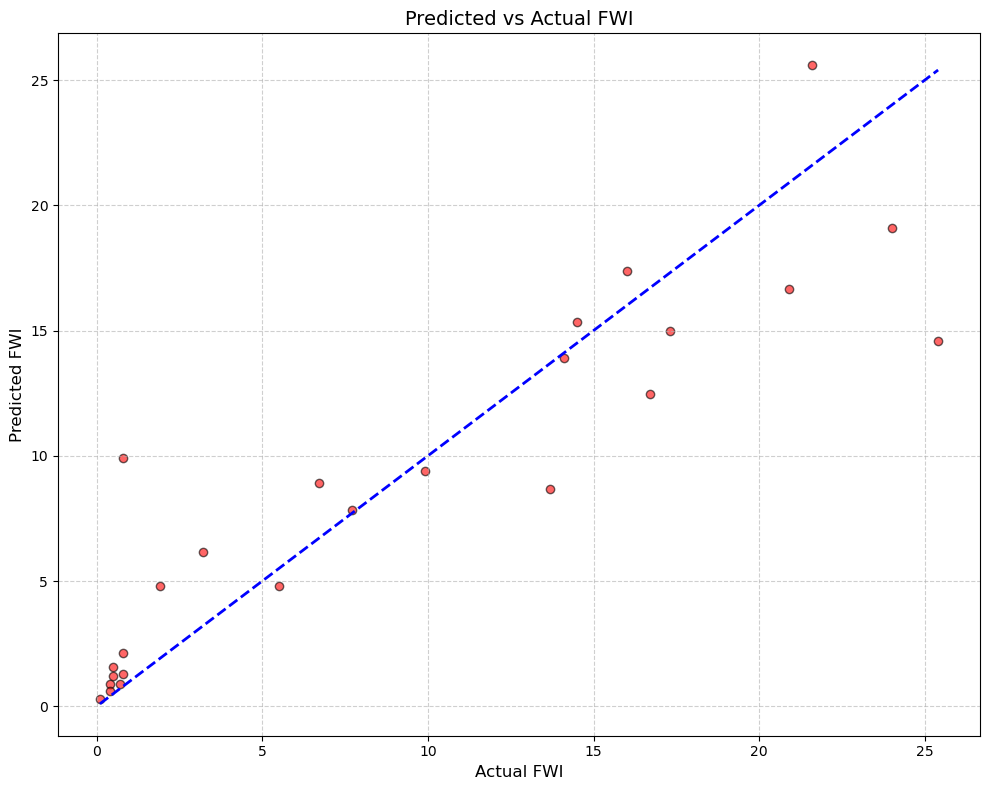

In [ ]:
def rf_objective(trial): #objective function for Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000), #total number of trees in the forest
        "max_depth": trial.suggest_int("max_depth", 3, 15), #maximum depth of each decision tree
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20), 
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
        "n_jobs": -1 #uses all CPU cores for faster computaiton
    }
    
    model = RandomForestRegressor(**params)   #random forest model is trained 
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study_rf = optuna.create_study(direction='minimize')  #Optuna hyperparameter optimisation is conducted 
study_rf.optimize(rf_objective, n_trials=100)
best_rf_params = study_rf.best_params
best_rf_params['random_state'] = 42
best_rf_params['n_jobs'] = -1

rf_model = RandomForestRegressor(**best_rf_params)  #using best parameters the model is then trained 
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, rf_preds))


plt.figure(figsize=(10, 8))
plt.scatter(y_test, rf_preds, color='red', alpha=0.6, edgecolor='black')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'b--', linewidth=2) 
plt.xlabel("Actual FWI", fontsize=12)
plt.ylabel("Predicted FWI", fontsize=12)
plt.title("Predicted vs Actual FWI", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#reference: https://medium.com/@ehsannabatchian/optimizing-random-forest-models-a-deep-dive-into-hyperparameter-tuning-with-optuna-b8e4fe7f3670